#**Курбаков Г.А. (МФТИ, М05-321ск)**

# Задачи для экзамена по курсу Численные методы выпуклой оптимизации, осень 2024

Решения задач должны быть выполнены студентом самостоятельно. При обнаружении похожих решений у разных студентов им всем будет поставлен 0 баллов за весь экзамен.

## **Задача 1 (10 pts)**

Пусть дан осциллирующий временой рад $y$, и вам необходимо построить его гладкую аппроксимацию, которая бы отслеживала изменение тренда в этом временном ряду.
Это можно сделать, решив следующую задачу оптимизации

$$ \min_x \| x - y \|^2_2 + \lambda \sum_{i=1}^{n-2} h_{\mu}([Dx]_i), $$

где $D$ - трёхдиагональная матрица с элементами (1, -2, 1) на главных диагоналях, такая что $[Dx]_i = x_i - 2 x_{i+1} + x_{i+2}, 1 \leq i \leq n-2$, функция $h_{\mu}(x) = \begin{cases} x^2 / 2\mu, & |x| \leq \mu \\ |x| - \mu/ 2, & |x| > \mu \end{cases}$ является дифференцируемой и выпуклой. Параметр $\lambda > 0$ задан, параметр $\mu > 0$ также необходимо задать заранее.

__1)__ (1 pts) докажите указанные выше свойства функции $h_{\mu}$

__2)__ (6 pts) сравните метод тяжёлого шарика, ускоренный градиентный метод и квазиньютоновский метод (LBFGS) для решения такой задачи. Значения $y$ можно взять из [файла](https://drive.google.com/file/d/15R9_atkEMiR3l_cOhK-PdvHsj8ecHJso/view?usp=sharing). Постройте графики сходимости и получите время работы каждого из меодов. Протестируйте несколько значений для размера шага в первых двух методах и размера истории в LBFGS. Какой метод оказался наилучшим для решения поставленной задачи и почему?

__3)__ (3 pts) Рассмотрите различные значения параметров $\lambda$ и $\mu$. Прокомментируйте, как их значения влияют на свойства решения.


##**Решение:**

__1)__ __Диффиринцируемость:__ $$h_{\mu}(x):$$
Для $$ |x| \leq \mu: $$
$$ h_{\mu}(x) = \frac {x^2}{2\mu} $$
Производная: $$ h_{\mu}'(x) = \frac{x}{\mu} $$
В точке $x = \pm \mu $ $$ h_{\mu}'(\pm \mu) = \pm 1 $$
Т.е. функция квадратичная, поэтому производная существует для всех $x$ внутри области

Для $$ |x| > \mu: $$
$$ h_{\mu}(x) = |x| - \frac{\mu}{2} $$

$$
h_{\mu}'(x) =
\begin{cases}
1, & x > \mu, \\
-1, & x < -\mu.
\end{cases}
$$
В точке $x = \pm \mu $ $$ h_{\mu}'(\pm \mu) = \pm 1 $$

Т.е. мы показали диффиринцируемость и для этой области

__Выпуклость:__

Для $|x| \leq \mu :$
$$
h_\mu(x) = \frac{x^2}{2\mu}, \quad h_\mu''(x) = \frac{1}{\mu} > 0.
$$
Функция квадратичная и явно выпуклая.

Для $|x| > \mu :$
$$
h_\mu(x) = |x| - \frac{\mu}{2}.
$$
Функция $|x|$ линейная на данном интервале, а линейные функции тоже выпуклы.

Проверка на стыке $$x = \pm \mu:$$
Выпуклость проверяется из условия:
$$
h_\mu(\theta x_1 + (1 - \theta)x_2) \leq \theta h_\mu(x_1) + (1 - \theta)h_\mu(x_2).
$$
В точках стыка $(x = \pm \mu)$ функция непрерывна, а её первая производная также непрерывна, что гарантирует выполнение условия выпуклости.


__2)__

In [115]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import diags

file_path = "ibm_data.csv"
data = pd.read_csv(file_path)  # Считывает CSV в DataFrame
y = data["Close"].values

In [116]:
lamb = 1.0
mu = 0.5

In [117]:
# Размерность n
n = len(y) # Например, для больших данных

# Создаем разреженную матрицу D
diagonals = [-2 * np.ones(n), np.ones(n - 1), np.ones(n - 1)]
D_sparse = diags(diagonals, [0, 1, -1], shape=(n, n), format="csr")

In [118]:
def h_mu(x, mu):
  return np.where(
      np.abs(x) <= mu,
      x**2 / (2 * mu),
      np.abs(x) - mu / 2
  )

def h_mu_derivative(x, mu):
  return np.where(
      np.abs(x) <= mu,
      x / mu,
      np.sign(x)
  )

def func(x, y, D_sparse, lamb, mu):
  #Целевая функция
  residual = x - y
  penalty = h_mu(D_sparse @ x, mu)
  return np.linalg.norm(residual)**2 + lamb * np.sum(penalty)

def grad_func(x, y, D_sparse, lamb, mu):
  #Градиент целевой ф-ии
  residual_grad = 2 * (x - y)
  penalty_grad = lamb * D_sparse.T @ h_mu_derivative(D_sparse @ x, mu)
  return residual_grad + penalty_grad

In [119]:
from scipy.optimize import minimize

In [126]:
# Алгоритм тяжелого шарика с сохранением промежуточных значений
def heavy_ball(grad, x0, eps, num_iter, lr, beta):
    conv = [x0]
    x = x0.copy()
    for iter_idx in range(num_iter):
        g = grad(x, y, D_sparse, lamb, mu)
        if np.linalg.norm(g) <= eps:
            break
        if iter_idx > 0:
            x = x - lr * g + beta * (x - conv[-2])
        else:
            x = x - lr * g
        conv.append(x.copy())
    return x, conv

# Ускоренный метод Нестерова с сохранением промежуточных значений
def acc_gd(grad, x0, eps, num_iter, lr):
    conv = [x0]
    x = x0.copy()
    y_ = x0.copy()
    for iter_idx in range(num_iter):
        g = grad(y_, y_, D_sparse, lamb, mu)
        if np.linalg.norm(g) <= eps:
            break
        x_next = y_ - lr * g
        y_ = x_next + (iter_idx + 1) / (iter_idx + 4) * (x_next - x)
        x = x_next.copy()
        conv.append(x.copy())
    return x, conv

def l_bfgs_b(grad, func, x0, y, D_sparse, lamb, mu, m):
    conv = [x0]  # Для сохранения промежуточных значений
    def callback(xk):
        conv.append(xk.copy())
    res = minimize(fun=lambda x: func(x, y, D_sparse, lamb, mu),
                   jac=lambda x: grad_func(x, y, D_sparse, lamb, mu),
                   x0=x0,
                   method="L-BFGS-B",
                   callback=callback,
               options={"maxcor": m})
    return res.x, conv

In [132]:
# Параметры для тестирования
x0 = np.zeros(n)  # Начальное приближение
lr_values = [0.01, 0.1, 0.001]  # Тестирование разных значений шага
beta = 0.9  # Коэффициент момента
num_iter = 30000
eps = 1e-6
lamb_values = [0.1, 1.0, 10.0]  # Тестирование разных значений lamb
mu_values = [0.1, 0.5, 1.0]  # Тестирование разных значений mu
m = 10 # Размер истории для L-BFGS (можно настроить)


In [122]:
import time

Тестирование: lr=0.01, lambda=0.1, mu=0.1


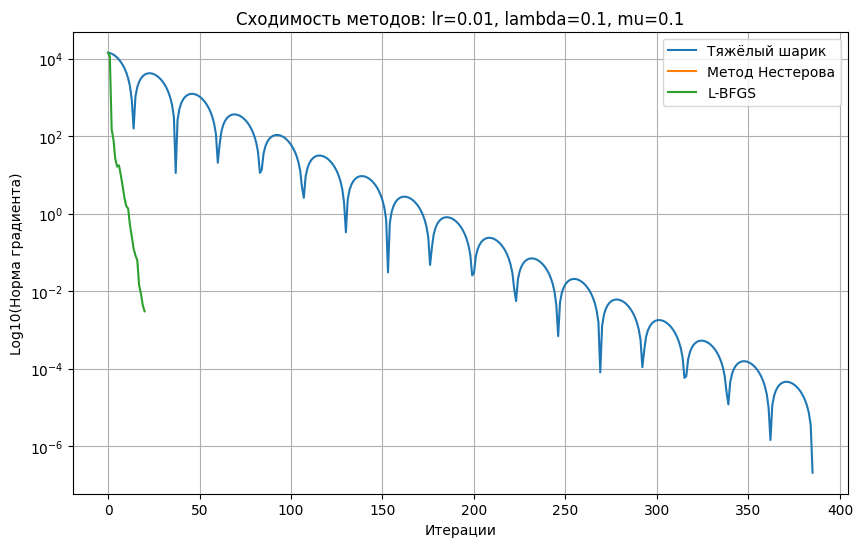

Время работы:
  Тяжёлый шарик: 0.2897 секунд
  Метод Нестерова: 0.0006 секунд
  L-BFGS: 0.3806 секунд
Тестирование: lr=0.01, lambda=0.1, mu=0.5


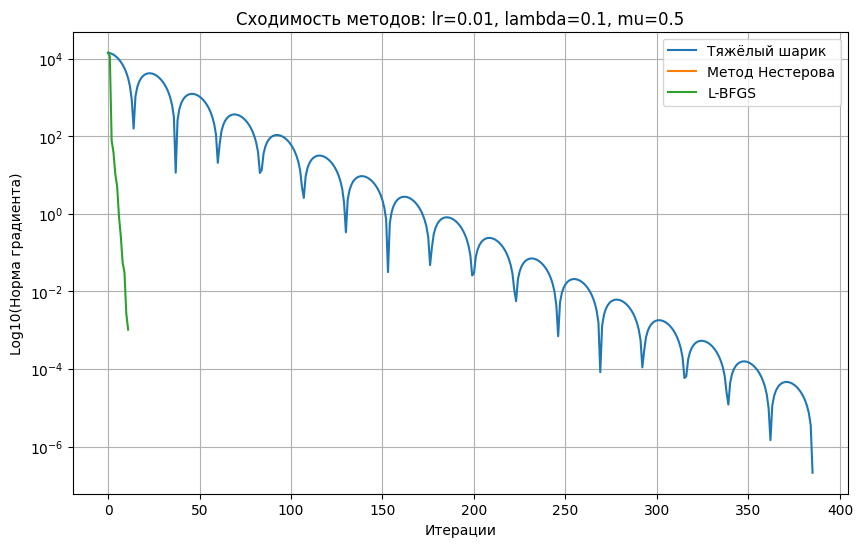

Время работы:
  Тяжёлый шарик: 0.3128 секунд
  Метод Нестерова: 0.0007 секунд
  L-BFGS: 0.2281 секунд
Тестирование: lr=0.01, lambda=0.1, mu=1.0


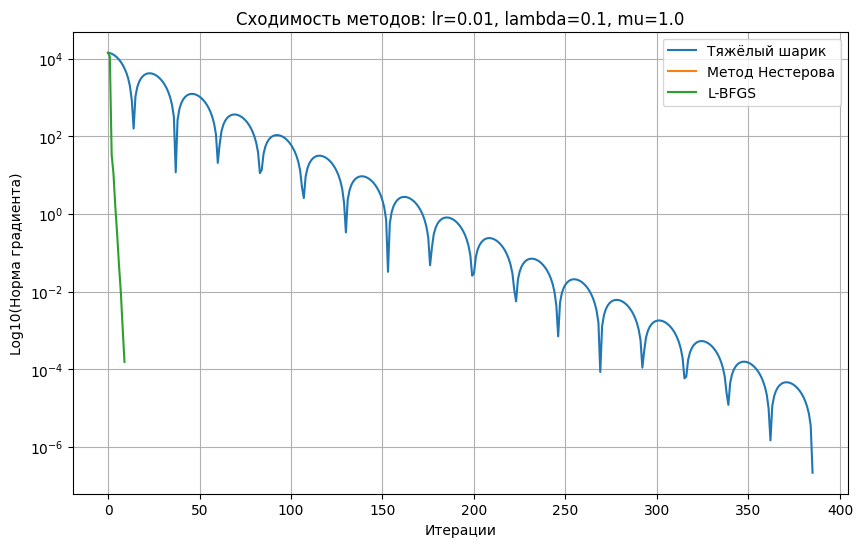

Время работы:
  Тяжёлый шарик: 0.3026 секунд
  Метод Нестерова: 0.0006 секунд
  L-BFGS: 0.1017 секунд
Тестирование: lr=0.01, lambda=1.0, mu=0.1


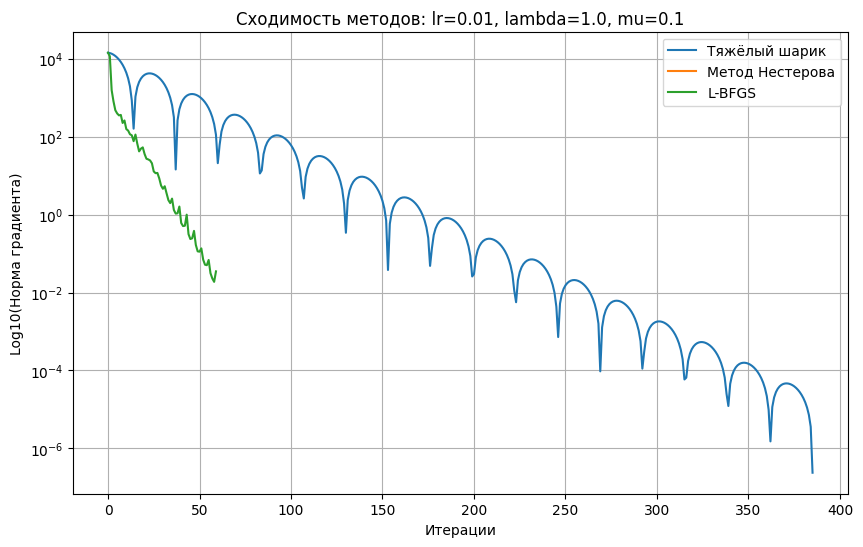

Время работы:
  Тяжёлый шарик: 0.3223 секунд
  Метод Нестерова: 0.0007 секунд
  L-BFGS: 0.4900 секунд
Тестирование: lr=0.01, lambda=1.0, mu=0.5


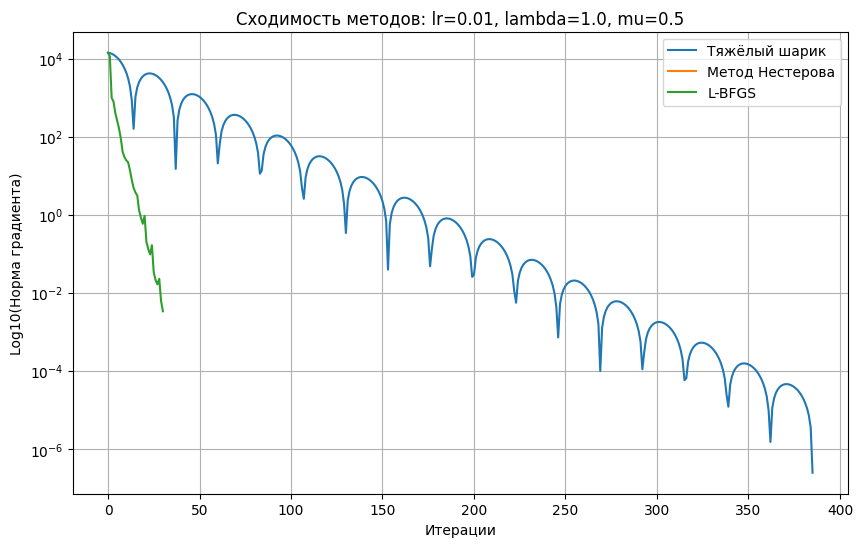

Время работы:
  Тяжёлый шарик: 0.3137 секунд
  Метод Нестерова: 0.0006 секунд
  L-BFGS: 0.2627 секунд
Тестирование: lr=0.01, lambda=1.0, mu=1.0


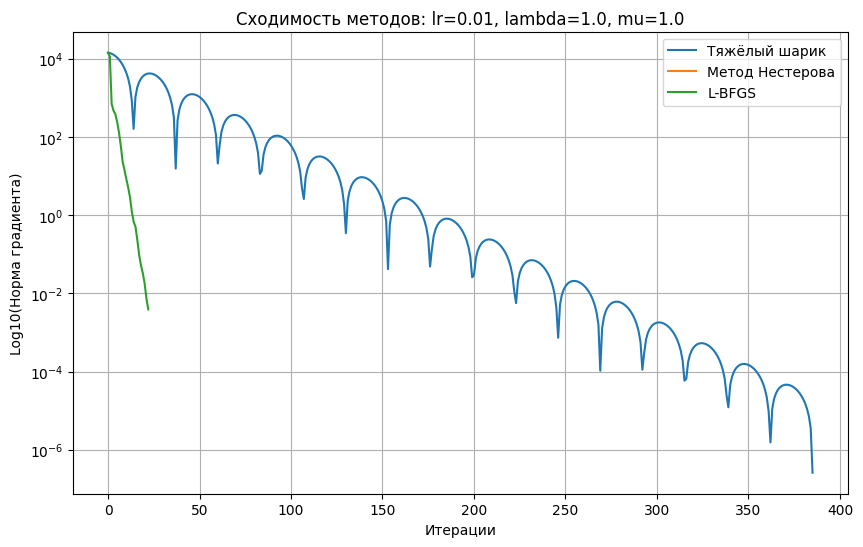

Время работы:
  Тяжёлый шарик: 0.3187 секунд
  Метод Нестерова: 0.0006 секунд
  L-BFGS: 0.2551 секунд
Тестирование: lr=0.01, lambda=10.0, mu=0.1


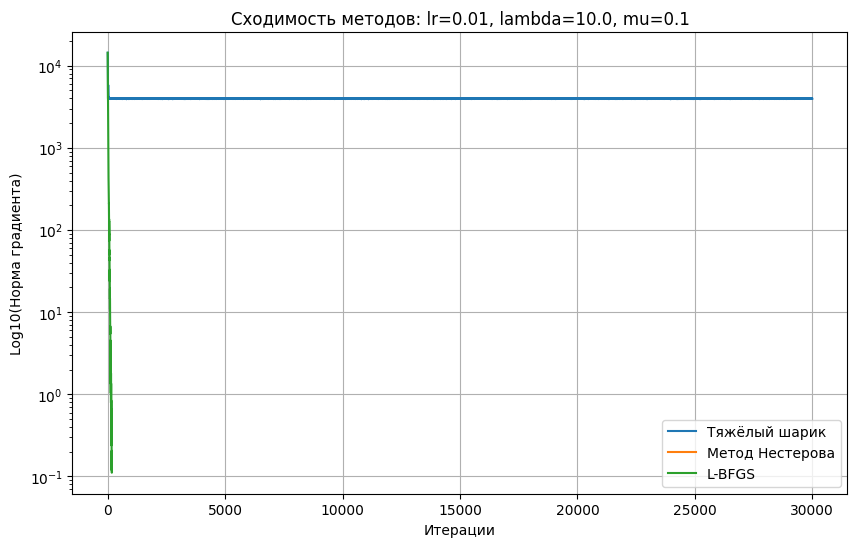

Время работы:
  Тяжёлый шарик: 31.2746 секунд
  Метод Нестерова: 0.0009 секунд
  L-BFGS: 1.4518 секунд
Тестирование: lr=0.01, lambda=10.0, mu=0.5


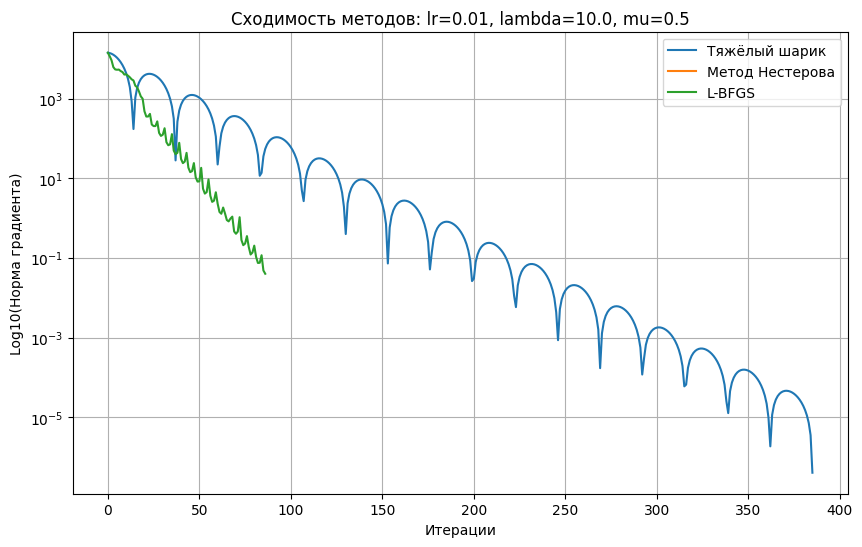

Время работы:
  Тяжёлый шарик: 0.3220 секунд
  Метод Нестерова: 0.0008 секунд
  L-BFGS: 0.8613 секунд
Тестирование: lr=0.01, lambda=10.0, mu=1.0


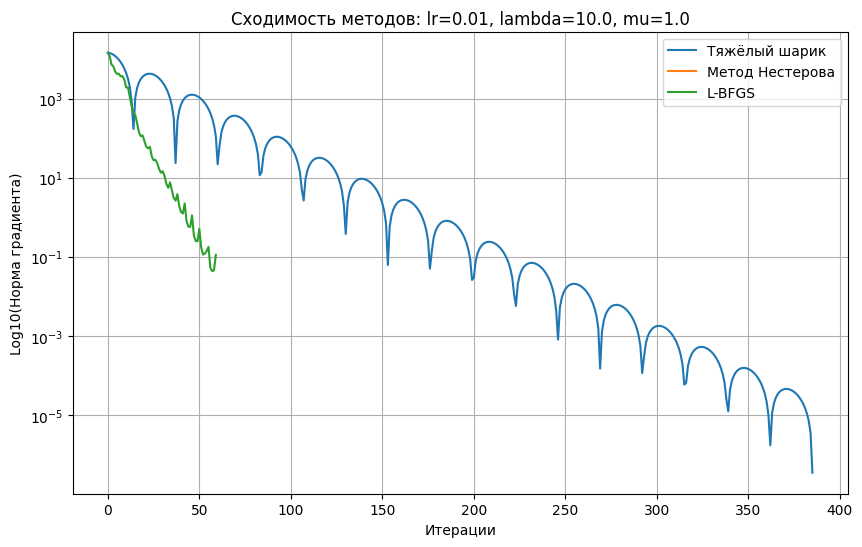

Время работы:
  Тяжёлый шарик: 0.3063 секунд
  Метод Нестерова: 0.0006 секунд
  L-BFGS: 0.6671 секунд
Тестирование: lr=0.1, lambda=0.1, mu=0.1


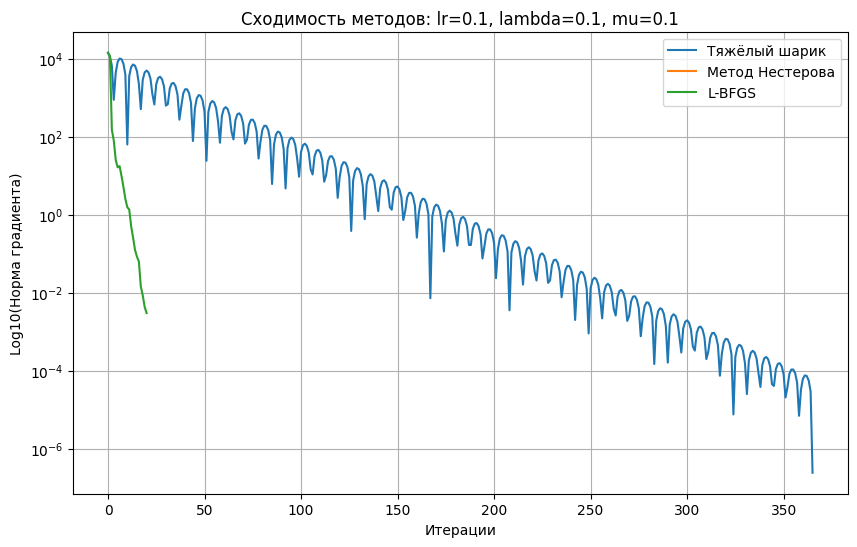

Время работы:
  Тяжёлый шарик: 0.3260 секунд
  Метод Нестерова: 0.0008 секунд
  L-BFGS: 0.2198 секунд
Тестирование: lr=0.1, lambda=0.1, mu=0.5


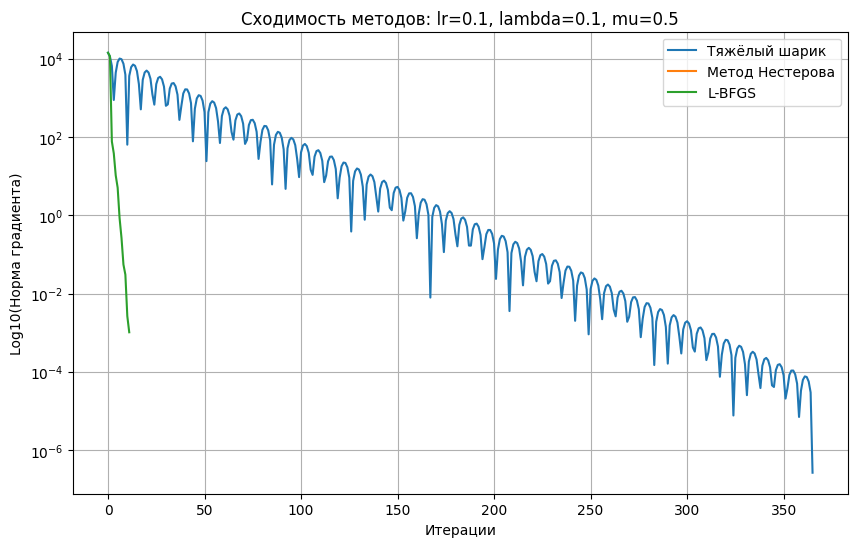

Время работы:
  Тяжёлый шарик: 0.3251 секунд
  Метод Нестерова: 0.0007 секунд
  L-BFGS: 0.2670 секунд
Тестирование: lr=0.1, lambda=0.1, mu=1.0


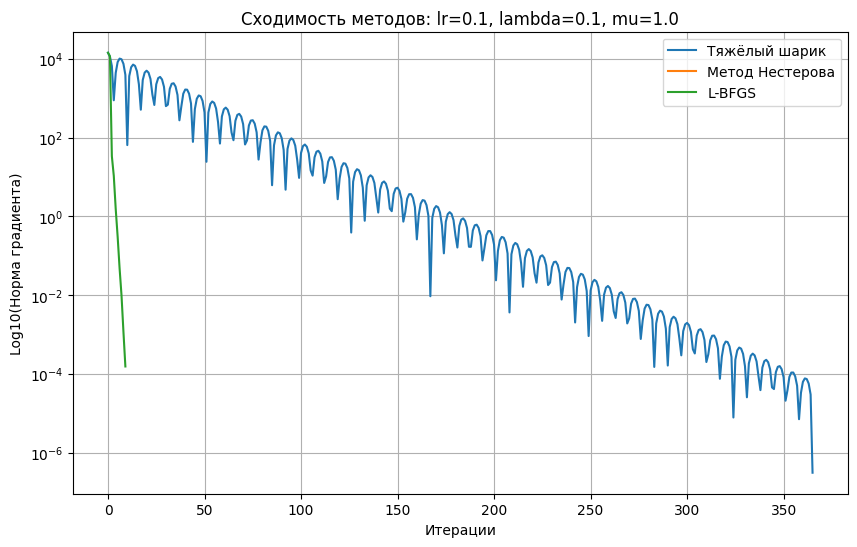

Время работы:
  Тяжёлый шарик: 0.3067 секунд
  Метод Нестерова: 0.0006 секунд
  L-BFGS: 0.2562 секунд
Тестирование: lr=0.1, lambda=1.0, mu=0.1


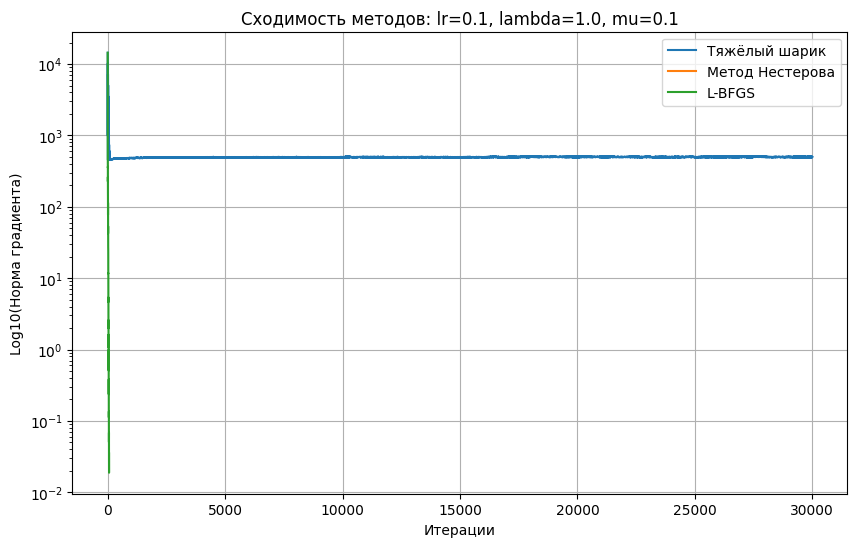

Время работы:
  Тяжёлый шарик: 32.7470 секунд
  Метод Нестерова: 0.0007 секунд
  L-BFGS: 0.6167 секунд
Тестирование: lr=0.1, lambda=1.0, mu=0.5


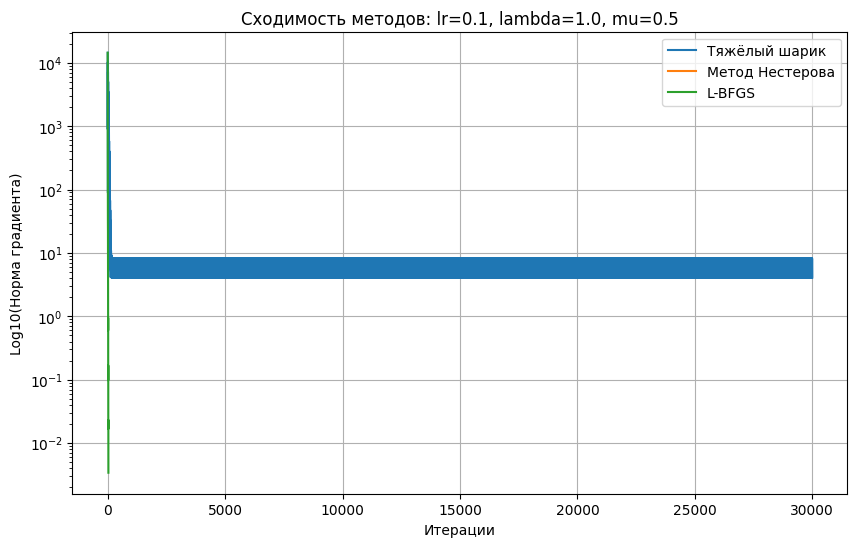

Время работы:
  Тяжёлый шарик: 30.2494 секунд
  Метод Нестерова: 0.0009 секунд
  L-BFGS: 0.2926 секунд
Тестирование: lr=0.1, lambda=1.0, mu=1.0


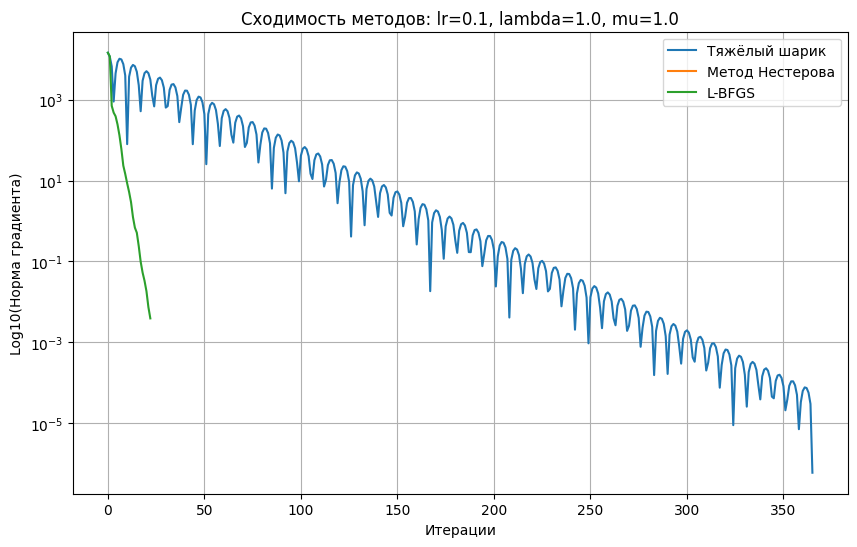

Время работы:
  Тяжёлый шарик: 0.6488 секунд
  Метод Нестерова: 0.0007 секунд
  L-BFGS: 0.9110 секунд
Тестирование: lr=0.1, lambda=10.0, mu=0.1


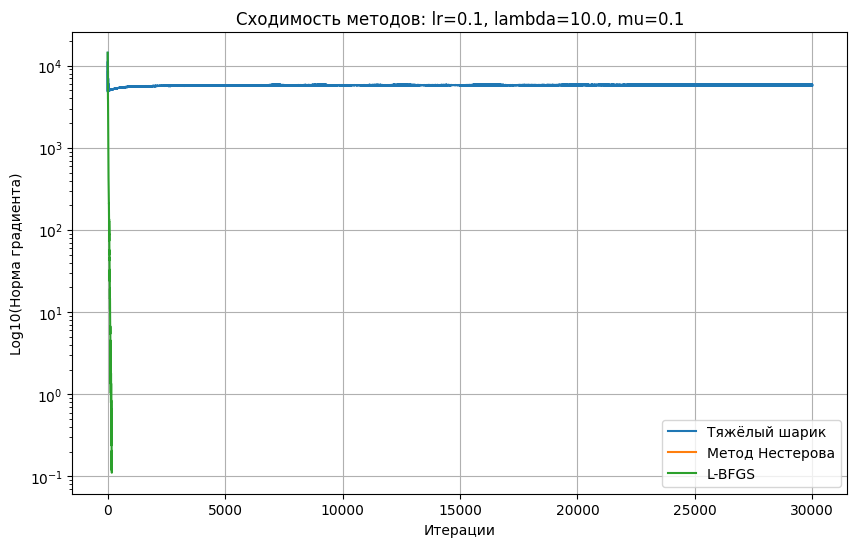

Время работы:
  Тяжёлый шарик: 25.1392 секунд
  Метод Нестерова: 0.0030 секунд
  L-BFGS: 2.1901 секунд
Тестирование: lr=0.1, lambda=10.0, mu=0.5


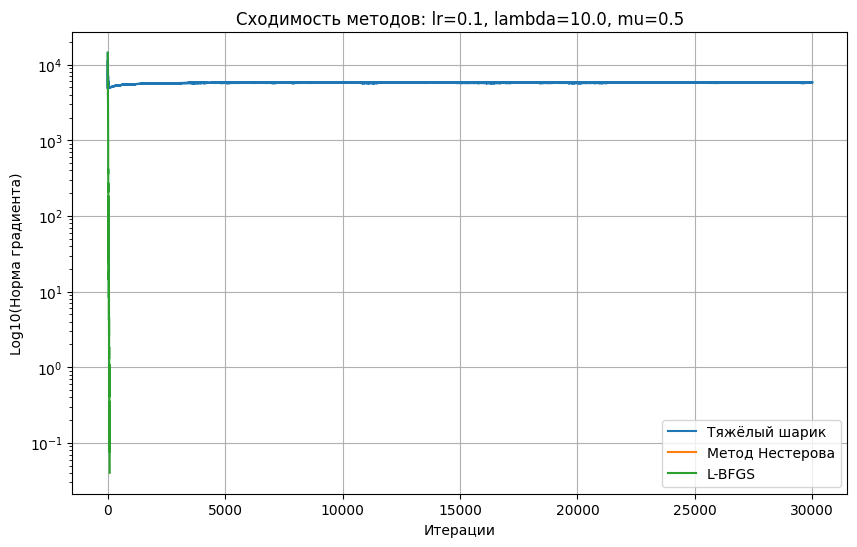

Время работы:
  Тяжёлый шарик: 24.8809 секунд
  Метод Нестерова: 0.0008 секунд
  L-BFGS: 2.3624 секунд
Тестирование: lr=0.1, lambda=10.0, mu=1.0


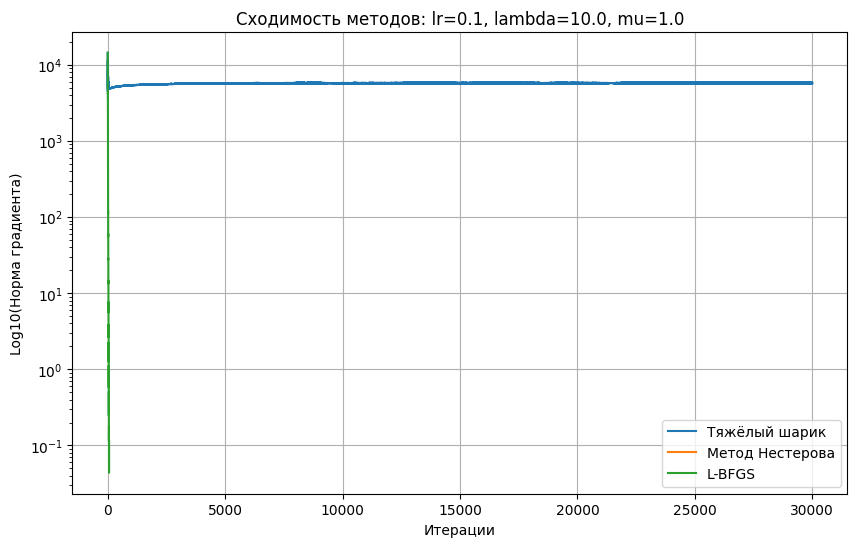

Время работы:
  Тяжёлый шарик: 25.9325 секунд
  Метод Нестерова: 0.0018 секунд
  L-BFGS: 0.5553 секунд
Тестирование: lr=0.001, lambda=0.1, mu=0.1


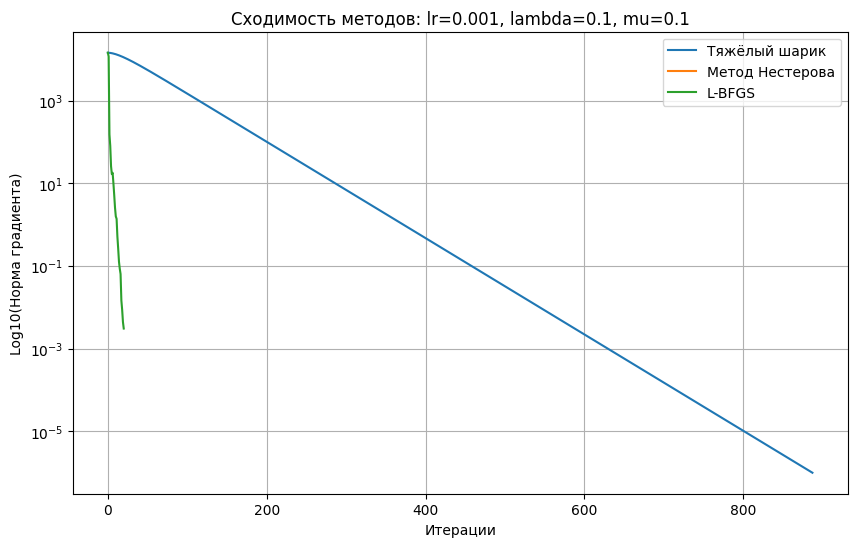

Время работы:
  Тяжёлый шарик: 2.7437 секунд
  Метод Нестерова: 0.0018 секунд
  L-BFGS: 0.6573 секунд
Тестирование: lr=0.001, lambda=0.1, mu=0.5


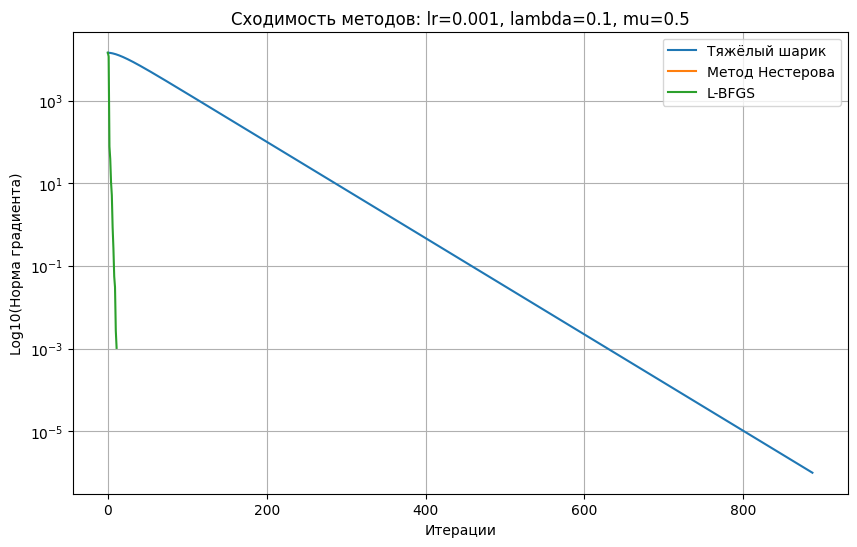

Время работы:
  Тяжёлый шарик: 1.1524 секунд
  Метод Нестерова: 0.0008 секунд
  L-BFGS: 0.2208 секунд
Тестирование: lr=0.001, lambda=0.1, mu=1.0


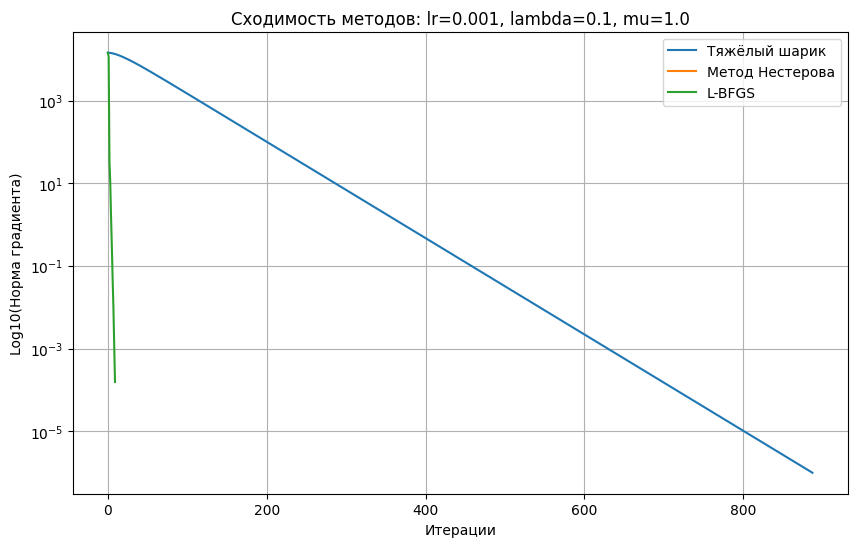

Время работы:
  Тяжёлый шарик: 0.8714 секунд
  Метод Нестерова: 0.0006 секунд
  L-BFGS: 0.1516 секунд
Тестирование: lr=0.001, lambda=1.0, mu=0.1


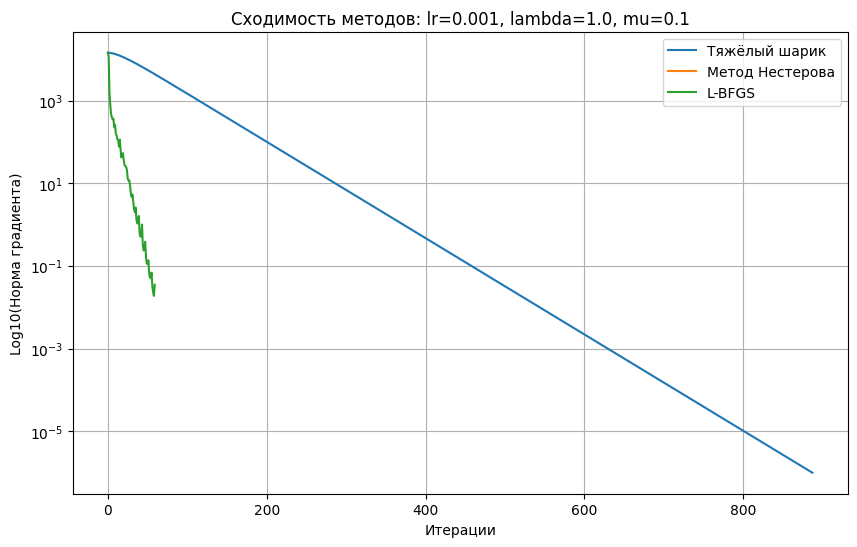

Время работы:
  Тяжёлый шарик: 0.8623 секунд
  Метод Нестерова: 0.0056 секунд
  L-BFGS: 0.5258 секунд
Тестирование: lr=0.001, lambda=1.0, mu=0.5


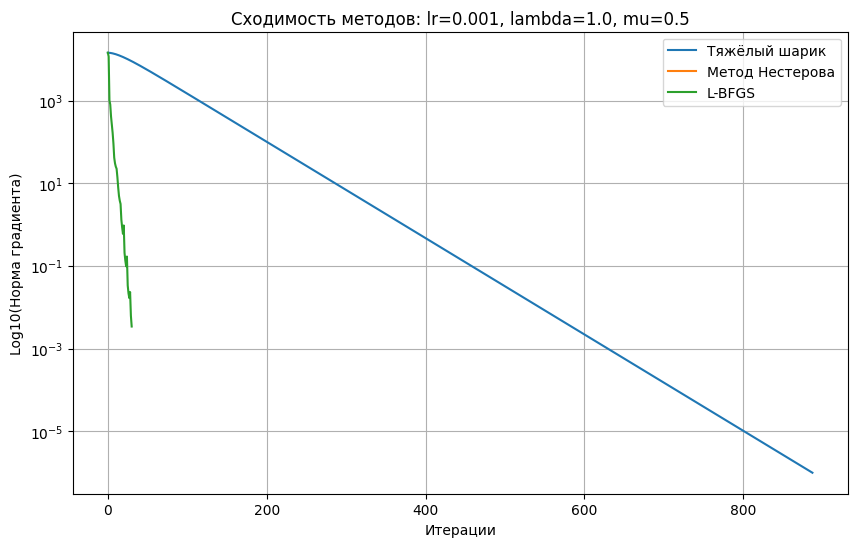

Время работы:
  Тяжёлый шарик: 1.0117 секунд
  Метод Нестерова: 0.0007 секунд
  L-BFGS: 1.5721 секунд
Тестирование: lr=0.001, lambda=1.0, mu=1.0


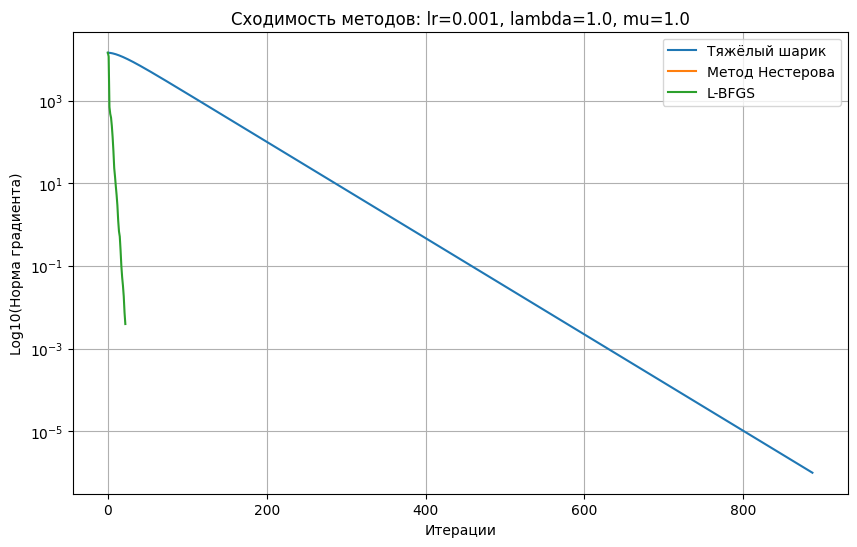

Время работы:
  Тяжёлый шарик: 0.8738 секунд
  Метод Нестерова: 0.0006 секунд
  L-BFGS: 0.4530 секунд
Тестирование: lr=0.001, lambda=10.0, mu=0.1


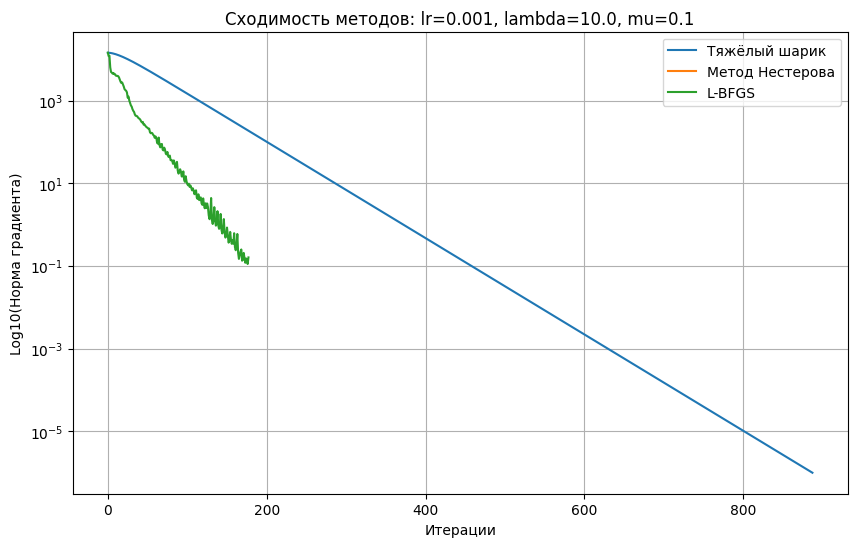

Время работы:
  Тяжёлый шарик: 0.9502 секунд
  Метод Нестерова: 0.0006 секунд
  L-BFGS: 2.6771 секунд
Тестирование: lr=0.001, lambda=10.0, mu=0.5


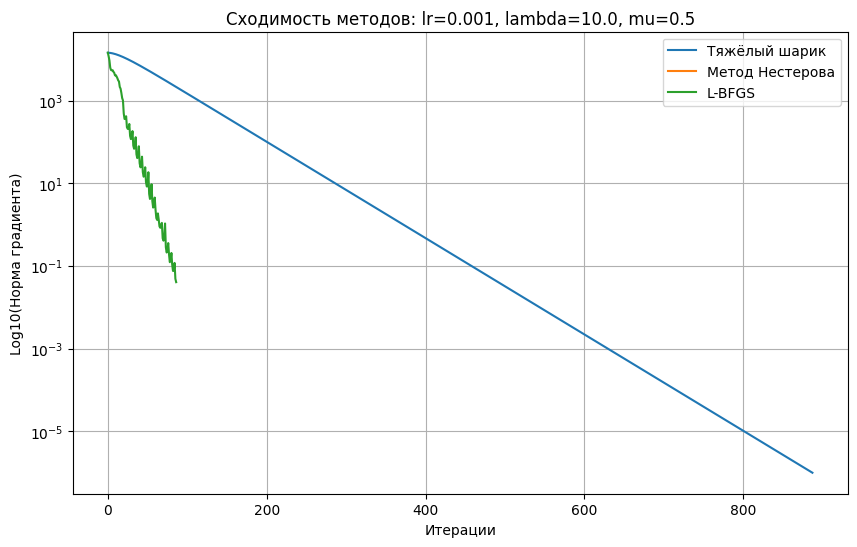

Время работы:
  Тяжёлый шарик: 1.7084 секунд
  Метод Нестерова: 0.0015 секунд
  L-BFGS: 3.5281 секунд
Тестирование: lr=0.001, lambda=10.0, mu=1.0


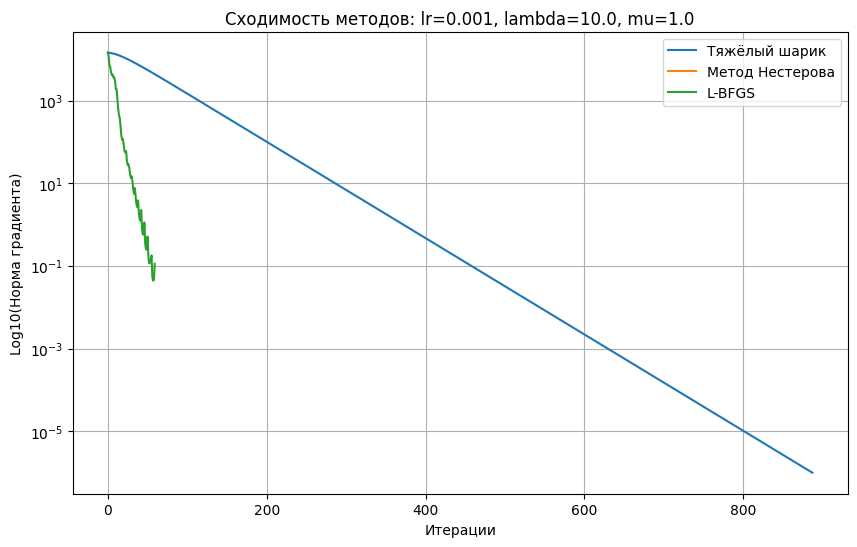

Время работы:
  Тяжёлый шарик: 0.9534 секунд
  Метод Нестерова: 0.0007 секунд
  L-BFGS: 0.5018 секунд


In [133]:
# Тестирование методов для различных параметров
for lr in lr_values:
    for lamb in lamb_values:
        for mu in mu_values:
            print(f"Тестирование: lr={lr}, lambda={lamb}, mu={mu}")

            # Тяжёлый шарик
            start_time = time.time()
            x_hb, conv_hb = heavy_ball(grad_func, x0, eps, num_iter, lr, beta)
            hb_time = time.time() - start_time

            # Метод Нестерова
            start_time = time.time()
            x_nag, conv_nag = acc_gd(grad_func, x0, eps, num_iter, lr)
            nag_time = time.time() - start_time

            # L-BFGS
            start_time = time.time()
            x_lbfgs, conv_lbfgs = l_bfgs_b(grad_func, func, x0, y, D_sparse, lamb, mu, m)
            lbfgs_time = time.time() - start_time

            # Построение графиков сходимости через нормы градиента
            plt.figure(figsize=(10, 6))
            plt.plot([np.linalg.norm(grad_func(x, y, D_sparse, lamb, mu)) for x in conv_hb], label="Тяжёлый шарик")
            plt.plot([np.linalg.norm(grad_func(x, y, D_sparse, lamb, mu)) for x in conv_nag], label="Метод Нестерова")
            plt.plot([np.linalg.norm(grad_func(x, y, D_sparse, lamb, mu)) for x in conv_lbfgs], label="L-BFGS")
            plt.yscale("log")
            plt.xlabel("Итерации")
            plt.ylabel("Log10(Норма градиента)")
            plt.title(f"Сходимость методов: lr={lr}, lambda={lamb}, mu={mu}")
            plt.legend()
            plt.grid(True)
            plt.show()

            # Вывод времени работы
            print(f"Время работы:")
            print(f"  Тяжёлый шарик: {hb_time:.4f} секунд")
            print(f"  Метод Нестерова: {nag_time:.4f} секунд")
            print(f"  L-BFGS: {lbfgs_time:.4f} секунд")

__3)__ Как можно видеть, наиболее быстр по времени всегда метод Нестерова (ускоренный градиентный спуск).
С увелечением $lambda$ увеличивается число итераций в L-BFGS необходимых для приближения, также при значительном увелечении $lambda$ метод тяжелого шарика значительно теряет в точности (при малом $μ$, с увелечением $μ$ операция выправляется).
Однако, с увелечение lr можем видеть увелечения нормы градиента.

Метод Нестерова (ускоренный градиентный спуск) **(почему-то не удалось отобразить)(поэтому для этого метода вывод без опоры на график, а только на данные работы):**

*   Быстрота: Метод Нестерова стабильно показал наибольшую скорость сходимости по времени, что свидетельствует о его эффективности на простых и средних задачах. Он сходится быстрее других методов, вероятно, из-за своей улучшенной стратегии шага, которая использует информацию о предыдущих обновлениях.
*   Гибкость: Метод хорошо работает при малых значениях λ и μ, где он может быстро адаптироваться и сходиться.
*   Погрешность и стабильность: Однако с увеличением значений λ и μ точность решения и стабильность сходимости метода Нестерова могут ухудшаться, особенно при больших значениях λ, где метод может не достигать нужной точности.


Метод L-BFGS:

*   Чувствительность к λ: Как показано, с увеличением λ для L-BFGS требуется больше итераций для сходимости, что связано с ростом штрафа, влияющего на сходимость. Это также указывает на то, что L-BFGS зависит от аппроксимации Гессиана, которая становится более чувствительной к большим значениям λ.
*   Точность: Несмотря на больший срок сходимости, L-BFGS обычно даёт более точные результаты, особенно при больших значениях λ, благодаря учёту кривизны целевой функции. Он способен точнее минимизировать функцию, что особенно важно для сложных задач.
*   Реакция на μ: При малом μ метод L-BFGS может показывать большую погрешность, но с увеличением μ (что выправляет основной функционал) его сходимость и точность становятся лучше.

Метод тяжёлого шарика:

*   Проблемы с точностью при большом λ: Метод тяжёлого шарика может значительно терять в точности при увеличении λ, что связано с тем, что штрафной член становится слишком большим и искажает основную задачу. При малом μ с увеличением λ погрешности возрастали, однако с увеличением μ погрешность уменьшалась, так как штрафной член становился более сбалансированным.
*   Повышение нормы градиента при большом lr: С увеличением lr для метода тяжёлого шарика наблюдается увеличение нормы градиента, что указывает на большую нестабильность сходимости. Иногда это приводит к несходимости при слишком большом lr.

## **Задача 2 (6 pts)**

Пусть даны два графа $G_A$ и $G_B$ с матрицами смежности $A$ и $B$ соответственно. [Задача об изоморфизме графов](https://en.wikipedia.org/wiki/Graph_isomorphism_problem) состоит в поиске такой матрицы перестановки $P$, что выполнено

$$
PAP^{\top} = B.
$$

На данный момент неизвестно является ли эта задача NP-полной или лежит в классе P.

1) (2 pts) запишите ограничения на искомую матрицу $P$ и покажите, что задача об изоморфизме графа может быть записана как бинарная задачу линейного программирования, то есть как задача линейного программирования, в которой элементами решения могут быть только 0 и 1. Вам необходимо привести целевую функцию в максимально простом виде (чем проще целевая функция, тем быстрее будет работать солвер), ключевое слово min или max, а также допустимое множество. (**Hint**: подумайте как задачу о существовании некоторого элемента в множестве записать в виде задачи оптимизации)

2) (2 pts) далее рассмотрите релаксацию поставленной задачи, в которой элементы решения могут принимать значения в отрезке $[0, 1]$. Если решение такой задачи не нашлось, то это значит, что графы не изоморфны. Если решение нашлось и элементы решения только 0 или 1, то найдена искомая перестановка. Конечно, такое случается достаточно редко. Чтобы форсировать бинарность элементов решения, к целевой функции исходной задачи можно добавить слагаемое вида $\langle W, P \rangle$, где $W$ некоторая случайная матрица, например с элементами из $N(0, 1)$ (возможно использование других распределений). Добавление такого слагаемого не повлияет на решение вопроса существования перестановки.

3) (2 pts) Убедитесь, что графы с матрицами смежности, заданными [тут](https://web.stanford.edu/~boyd/cvxbook/cvxbook_additional_exercises/graph_isomorphism_data.py), являются изоморфными с помощью cvxpy. Для поиска матрицы перестановки, возможно, необходимо решать несколько задач линейного программирования для разных матриц $W$. Также рассмотрите несколько распределений для генерации матрицы $W$. Убедитесь, что найденная матрица действительно является матрицей перестановки. Для проверки бинарности элементов можно отслеживать величину $\max_{(i, j)} P_{ij}(1 - P_{ij})$. После обнаружения матрицы перестановки выведите результат умножения матрицы $P^*$ на вектор $[1, 2, \ldots, n]$ для демонстрации того, как надо переставить вершины исходного графа.

##__1):__

Задачу о существовании искомой матрицы перестановки $P$ запишем как задачу оптимизации, минимизируя не саму разность между $PAP^\top$ и $B$, а делая акцент на поиск допустимой перестановочной матрицы с минимальными отклонениями.

## Постановка задачи
Задача состоит в том, чтобы найти матрицу перестановки \(P\), такую что:

$$
PAP^\top = B.
$$
### Переформулировка как задача оптимизации
Вместо того чтобы напрямую минимизировать отклонение, мы минимизируем ошибку, отражающую расхождение между $PAP^\top$ и $B$. Для этого вводим бинарные переменные и ограничения.

#### Бинарные переменные
- Матрица $P$ должна быть бинарной, с элементами $P_{ij} \in \{0, 1\}$, и удовлетворять условиям перестановки:
  $$
  \sum_j P_{ij} = 1 \quad \forall i, \quad \sum_i P_{ij} = 1 \quad \forall j.
  $$

#### Ошибочная переменная
Переменная $e_{ij}$ равна 0, если соответствующие элементы $PAP^\top$ и $B$ совпадают, и ненулевая в противном случае:
$$
e_{ij} \geq P \cdot A \cdot P^\top_{ij} - B_{ij}, \quad e_{ij} \geq B_{ij} - P \cdot A \cdot P^\top_{ij}, \quad e_{ij} \in \{0, 1\}.
$$

### Целевая функция
Задача сводится к минимизации суммы ошибок:
$$
\text{min} \quad \sum_{i, j} e_{ij},
$$
где $e_{ij}$ отражает расхождение между $PAP^\top$ и $B$.

### Ограничения
1. Перестановочные условия для матрицы $P$:
   $$
   \sum_j P_{ij} = 1 \quad \forall i, \quad \sum_i P_{ij} = 1 \quad \forall j, \quad P_{ij} \in \{0, 1\}.
   $$
2. Определение ошибок $e_{ij}$:
   $$
   e_{ij} \geq P \cdot A \cdot P^\top_{ij} - B_{ij}, \quad e_{ij} \geq B_{ij} - P \cdot A \cdot P^\top_{ij}, \quad e_{ij} \in \{0, 1\}.
   $$

Задача минимизирует сумму ошибок $e_{ij}$, которая показывает расхождения между соответствующими элементами матриц $PAP^\top$ и $B$.
Если оптимальное значение целевой функции равно 0, то
$PAP^\top = B$, и графы изоморфны.

##__2):__

## Рассмотрение релаксации задачи об изоморфизме графов

Применим **релаксацию**:
элементы искомой матрицы $P$ могут принимать значения в диапазоне $[0, 1]$, а не только бинарные значения $\{0, 1\}$.

## Релаксация постановки
### Релаксация матрицы $P$
Вместо жесткого условия $P_{ij} \in \{0, 1\}$ допускается:
$$
P_{ij} \in [0, 1].
$$

### Целевая функция и ограничения
Целевая функция и ограничения остаются теми же. Минимизируется сумма ошибок $e_{ij}$, возникающих при отклонениях между $PAP^\top$ и $B$:
$$
\text{min} \quad \sum_{i, j} e_{ij},
$$
при следующих ограничениях:
1. Перестановочные условия для $P$:
   $$
   \sum_j P_{ij} = 1 \quad \forall i, \quad \sum_i P_{ij} = 1 \quad \forall j.
   $$
2. Определение ошибок $e_{ij}$:
   $$
   e_{ij} \geq P \cdot A \cdot P^\top_{ij} - B_{ij}, \quad e_{ij} \geq B_{ij} - P \cdot A \cdot P^\top_{ij}.
   $$

---

## Что означает решение релаксированной задачи?
### Если решение не найдено
Если релаксированная задача не имеет решения, графы $G_A$ и $G_B$ не изоморфны.

### Если решение найдено
- Если все элементы матрицы $P$ бинарны $(0$ или $1)$, графы изоморфны, и найдена искомая перестановка.
- Если элементы $P$ имеют значения в $[0, 1]$, это может указывать на неполное решение. В таком случае необходимо форсировать бинарность для проверки изоморфизма.

---

## Форсирование бинарности с добавлением случайной матрицы $W$
Чтобы усилить вероятность получения бинарного решения, можно модифицировать целевую функцию, добавив слагаемое, направленное на форсирование бинарности. Введем случайную матрицу $W$ с элементами, распределенными по $N(0, 1)$ или другому распределению:
$$
\langle W, P \rangle = \sum_{i, j} W_{ij} P_{ij},
$$
где $W_{ij}$ — элементы случайной матрицы.

### Новая целевая функция
Модифицированная целевая функция примет вид:
$$
\text{min} \quad \sum_{i, j} e_{ij} + \langle W, P \rangle = \text{min} \quad \sum_{i, j} \left(e_{ij} + W_{ij} P_{ij}\right).
$$

---

## Обоснование
Добавление случайной матрицы $W$:
- Не изменяет основной смысл задачи — наличие или отсутствие изоморфизма.
- Форсирует элементы $P$ к крайним значениям ($0$ или $1$), увеличивая вероятность получения перестановочной матрицы.

### Примечания
- Слагаемое $\langle W, P \rangle$ влияет только на форму решения, не изменяя факт наличия изоморфизма.

##__3):__

In [39]:
# Data file for graph isomorphism problem. A and B are adjacency matrices
# of two isomorphic graphs

import numpy as np
A = np.array(np.mat(
'0  1  0  0  0  0  1  0  0  0  1  1  1  0  0  1  0  1  1  0  1  1  0  1  0  1  1  1  0  1;\
 1  0  0  0  0  0  1  1  0  0  1  0  1  0  0  1  1  0  0  0  0  0  0  0  1  0  0  1  1  0;\
 0  0  0  1  1  1  0  0  0  0  1  1  0  1  0  1  0  0  0  1  1  0  1  0  1  1  0  1  1  0;\
 0  0  1  0  0  1  0  0  1  0  0  0  1  1  0  0  0  1  1  1  1  0  0  1  0  0  0  1  0  1;\
 0  0  1  0  0  1  0  0  1  1  0  0  0  0  0  1  0  0  1  0  0  0  0  1  1  0  1  0  0  1;\
 0  0  1  1  1  0  0  1  0  1  1  1  1  0  1  0  1  1  1  1  1  1  1  1  1  1  0  1  1  1;\
 1  1  0  0  0  0  0  1  1  0  0  1  0  0  0  1  0  0  1  0  0  1  0  0  0  0  1  0  1  1;\
 0  1  0  0  0  1  1  0  0  1  1  0  0  1  0  1  0  0  1  0  0  1  1  1  0  1  0  1  0  0;\
 0  0  0  1  1  0  1  0  0  1  1  0  0  1  1  1  1  1  1  0  1  0  0  1  0  0  0  1  0  1;\
 0  0  0  0  1  1  0  1  1  0  0  0  1  1  0  1  0  0  0  0  0  1  0  1  0  0  0  0  0  0;\
 1  1  1  0  0  1  0  1  1  0  0  1  0  0  0  0  1  0  0  0  1  1  0  1  0  1  1  1  0  1;\
 1  0  1  0  0  1  1  0  0  0  1  0  0  0  0  0  1  1  0  0  0  0  0  0  1  0  0  1  1  0;\
 1  1  0  1  0  1  0  0  0  1  0  0  0  1  1  1  0  0  0  0  1  0  1  0  1  1  0  1  1  0;\
 0  0  1  1  0  0  0  1  1  1  0  0  1  0  0  1  0  0  1  0  1  0  0  1  0  0  0  1  0  1;\
 0  0  0  0  0  1  0  0  1  0  0  0  1  0  0  1  0  0  1  1  0  0  0  1  1  0  1  0  0  1;\
 1  1  1  0  1  0  1  1  1  1  0  0  1  1  1  0  0  1  0  1  1  1  1  1  1  1  0  1  1  1;\
 0  1  0  0  0  1  0  0  1  0  1  1  0  0  0  0  0  1  1  0  0  1  0  0  0  0  1  0  1  1;\
 1  0  0  1  0  1  0  0  1  0  0  1  0  0  0  1  1  0  0  1  0  1  1  1  0  1  0  1  0  0;\
 1  0  0  1  1  1  1  1  1  0  0  0  0  1  1  0  1  0  0  1  1  0  0  1  0  0  0  1  0  1;\
 0  0  1  1  0  1  0  0  0  0  0  0  0  0  1  1  0  1  1  0  0  1  0  1  0  0  0  0  0  0;\
 1  0  1  1  0  1  0  0  1  0  1  0  1  1  0  1  0  0  1  0  0  1  0  0  0  0  1  0  0  0;\
 1  0  0  0  0  1  1  1  0  1  1  0  0  0  0  1  1  1  0  1  1  0  0  0  0  0  1  1  0  0;\
 0  0  1  0  0  1  0  1  0  0  0  0  1  0  0  1  0  1  0  0  0  0  0  1  1  1  0  0  0  0;\
 1  0  0  1  1  1  0  1  1  1  1  0  0  1  1  1  0  1  1  1  0  0  1  0  0  1  0  0  1  0;\
 0  1  1  0  1  1  0  0  0  0  0  1  1  0  1  1  0  0  0  0  0  0  1  0  0  1  0  0  1  1;\
 1  0  1  0  0  1  0  1  0  0  1  0  1  0  0  1  0  1  0  0  0  0  1  1  1  0  0  1  0  1;\
 1  0  0  0  1  0  1  0  0  0  1  0  0  0  1  0  1  0  0  0  1  1  0  0  0  0  0  1  1  0;\
 1  1  1  1  0  1  0  1  1  0  1  1  1  1  0  1  0  1  1  0  0  1  0  0  0  1  1  0  0  1;\
 0  1  1  0  0  1  1  0  0  0  0  1  1  0  0  1  1  0  0  0  0  0  0  1  1  0  1  0  0  1;\
 1  0  0  1  1  1  1  0  1  0  1  0  0  1  1  1  1  0  1  0  0  0  0  0  1  1  0  1  1  0'))

B = np.array(np.mat(
'0  1  0  1  1  1  1  1  1  1  0  1  1  0  1  1  1  0  1  0  1  1  1  1  1  1  0  1  0  1;\
 1  0  1  0  0  0  1  0  1  0  0  0  0  1  0  1  0  1  1  1  0  0  1  1  1  0  0  1  0  0;\
 0  1  0  0  1  0  1  0  1  0  0  0  0  0  0  1  0  1  0  1  1  0  0  0  0  0  0  1  0  1;\
 1  0  0  0  1  0  0  0  1  0  1  1  0  0  0  1  1  1  1  1  1  1  0  1  0  0  0  1  1  0;\
 1  0  1  1  0  0  0  1  0  0  1  0  0  1  0  0  1  0  1  0  0  1  0  0  0  1  0  0  0  0;\
 1  0  0  0  0  0  1  1  1  1  0  1  1  1  1  0  0  0  1  0  1  0  0  0  0  0  0  1  1  1;\
 1  1  1  0  0  1  0  0  1  0  1  0  1  0  1  1  1  1  0  0  0  1  0  1  0  0  1  1  0  0;\
 1  0  0  0  1  1  0  0  0  1  0  0  1  1  1  0  1  0  0  0  1  0  0  0  0  1  1  0  0  1;\
 1  1  1  1  0  1  1  0  0  0  1  1  0  1  0  0  0  1  0  0  0  0  0  0  0  1  0  0  1  0;\
 1  0  0  0  0  1  0  1  0  0  0  0  1  1  0  0  0  0  0  0  0  1  1  1  0  1  0  0  0  0;\
 0  0  0  1  1  0  1  0  1  0  0  1  0  1  0  1  1  0  0  1  1  1  1  0  1  0  0  1  1  0;\
 1  0  0  1  0  1  0  0  1  0  1  0  0  0  0  0  1  0  1  0  0  1  1  0  0  1  0  1  1  0;\
 1  0  0  0  0  1  1  1  0  1  0  0  0  1  0  0  1  1  0  0  0  1  1  1  0  1  0  1  0  0;\
 0  1  0  0  1  1  0  1  1  1  1  0  1  0  0  0  1  1  1  1  1  1  1  1  1  1  1  1  1  1;\
 1  0  0  0  0  1  1  1  0  0  0  0  0  0  0  1  0  1  0  1  0  0  1  0  0  0  0  1  0  1;\
 1  1  1  1  0  0  1  0  0  0  1  0  0  0  1  0  1  0  0  0  0  0  1  0  0  0  1  0  0  1;\
 1  0  0  1  1  0  1  1  0  0  1  1  1  1  0  1  0  1  0  1  1  0  0  0  0  0  0  1  1  1;\
 0  1  1  1  0  0  1  0  1  0  0  0  1  1  1  0  1  0  0  1  0  1  1  0  0  1  1  1  0  0;\
 1  1  0  1  1  1  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  1  1  0  0  0  0  0  0  0;\
 0  1  1  1  0  0  0  0  0  0  1  0  0  1  1  0  1  1  0  0  0  0  0  1  0  0  1  0  0  1;\
 1  0  1  1  0  1  0  1  0  0  1  0  0  1  0  0  1  0  0  0  0  1  0  0  1  0  0  0  0  0;\
 1  0  0  1  1  0  1  0  0  1  1  1  1  1  0  0  0  1  1  0  1  0  1  1  1  0  0  0  1  1;\
 1  1  0  0  0  0  0  0  0  1  1  1  1  1  1  1  0  1  1  0  0  1  0  0  0  0  0  1  0  0;\
 1  1  0  1  0  0  1  0  0  1  0  0  1  1  0  0  0  0  0  1  0  1  0  0  1  0  1  1  1  0;\
 1  1  0  0  0  0  0  0  0  0  1  0  0  1  0  0  0  0  0  0  1  1  0  1  0  1  0  0  1  0;\
 1  0  0  0  1  0  0  1  1  1  0  1  1  1  0  0  0  1  0  0  0  0  0  0  1  0  1  1  1  1;\
 0  0  0  0  0  0  1  1  0  0  0  0  0  1  0  1  0  1  0  1  0  0  0  1  0  1  0  1  0  1;\
 1  1  1  1  0  1  1  0  0  0  1  1  1  1  1  0  1  1  0  0  0  0  1  1  0  1  1  0  1  0;\
 0  0  0  1  0  1  0  0  1  0  1  1  0  1  0  0  1  0  0  0  0  1  0  1  1  1  0  1  0  0;\
 1  0  1  0  0  1  0  1  0  0  0  0  0  1  1  1  1  0  0  1  0  1  0  0  0  1  1  0  0  0'))


In [46]:
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCIP', 'SCIPY', 'SCS']


In [58]:
import numpy as np
import cvxpy as cp


# Матрицы смежности
A = np.array(A)
B = np.array(B)
n = A.shape[0]

# Функция для проверки изоморфизма
def solve_isomorphism_fixed(A, B, num_trials=10, random_seed=42):
    np.random.seed(random_seed)
    for trial in range(num_trials):
        # Случайная матрица W
        W = np.random.normal(0, 1, (n, n))

        # Переменные CVXPY
        P = cp.Variable((n, n))

        # Целевая функция: минимизация разницы между PA и BP
        objective = cp.Minimize(cp.norm(P @ A - B @ P, "fro") + cp.trace(W.T @ P))

        # Ограничения
        constraints = [
            P >= 0,
            P <= 1,
            cp.sum(P, axis=0) == 1,  # Строки суммы 1
            cp.sum(P, axis=1) == 1,  # Столбцы суммы 1
        ]

        # Решение задачи
        problem = cp.Problem(objective, constraints)
        problem.solve(solver=cp.CLARABEL)

        # Проверка бинарности
        P_opt = P.value
        max_deviation = np.max(P_opt * (1 - P_opt))
        print(f"Trial {trial + 1}: Max deviation from binary = {max_deviation:.5f}")

        if max_deviation < 1e-3:  # Решение близко к бинарному
            print("Графы изоморфны!")
            print("Матрица перестановки P*:")
            print(P_opt)

            # Вычисление перестановки
            permutation = np.argmax(P_opt, axis=1)
            print("Перестановка вершин:", permutation)
            print("Результат умножения [1, 2, ..., n]:", permutation + 1)
            return

    print("Не удалось найти бинарное решение. Проверьте параметры задачи.")

# Решение задачи
solve_isomorphism_fixed(A, B)


Trial 1: Max deviation from binary = 0.25000
Trial 2: Max deviation from binary = 0.24998
Trial 3: Max deviation from binary = 0.24957
Trial 4: Max deviation from binary = 0.24996
Trial 5: Max deviation from binary = 0.24999
Trial 6: Max deviation from binary = 0.25000
Trial 7: Max deviation from binary = 0.24995
Trial 8: Max deviation from binary = 0.24934
Trial 9: Max deviation from binary = 0.24998
Trial 10: Max deviation from binary = 0.25000
Не удалось найти бинарное решение. Проверьте параметры задачи.


## **Задача 3 (10 pts)**

__1.__ Скачайте с помощью кода, приведённого ниже, набор фотографий и нарисуйте какую-нибудь из них.

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Shape of data = (400, 64, 64)


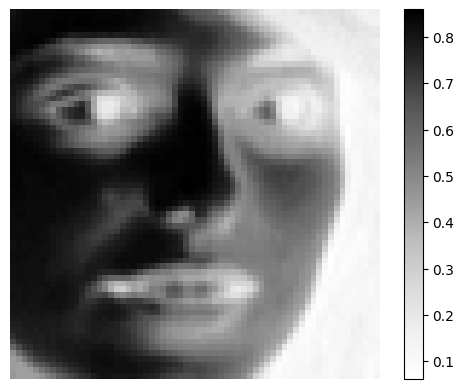

In [134]:
import sklearn.datasets as skldata
import matplotlib.pyplot as plt
import sklearn.decomposition as skdec
%matplotlib inline
data = skldata.fetch_olivetti_faces()
import numpy as np
print("Shape of data = {}".format(data["images"].shape))
index = 73
plt.imshow(data["images"][index], cmap=plt.cm.Greys)
plt.colorbar()
_ = plt.axis("off")

__2.__ Одним из способов обработки изображений, например для выделения наиболее важных сегментов используется метод неотрицательной матричной факторизации ([Nonnegative matrix factorization](https://arxiv.org/pdf/1401.5226.pdf)).
Идея в том, чтобы решить следующую задачу

\begin{align*}
& \min_{W, H} \frac12 \|X - WH\|^2_F \\
\text{s.t. } & W \geq 0\\
& H \geq 0,
\end{align*}

где знак $\geq$ означает покомпонентное сравнение.
Также матрицы $W$ и $H$ малого ранга, то есть $W \in \mathbb{R}^{m \times k}$ и $H \in \mathbb{R}^{k \times n}$, где $k$ - параметр, который необходимо настраивать.
Чем больше $k$, тем точнее приближение, но и тем дольше будет решаться задача.
Матрица $X \in \mathbb{R}^{m \times n}$, где $m$ - это число фото в нашем наборе, а $n$ - это количество пикселей в каждой картинке, то есть каждая строка матрицы $X$ - это векторизованная картинка.

**Вопросы**

1) (1 pts) является ли эта задача выпуклой и почему?

2) (1 pts) как можно интерпретировать факторы $W$ и $H$ и почему важна их покомпонентная неотрицательность?

3) (6 pts) примените проксимальный градиентный метод и его ускоренную версию для поиска локального минимума поставленной задачи, нарисуйте графики сходимости и прокомментируйте результаты. Если на всех данных метод работает долго, выберете некоторое количество достаточно разнообразных фото, чтобы свойства результата сохранились.

4) (1 pts) поскольку размерность $H$ - $k \times n$, то каждую строку $H$ можно преобразовать в картинку аналогично тому, как были собраны строки матрицы $X$. Нарисуйте 10-50 картинок полученных из строк матрицы $H$. Что Вы заметили и как это соотносится с ответами на вопрос 2) предыдущего пункта? Используйте ```plt.colorbar()``` и цветовую схему ```plt.cm.Greys``` для более чёткого отображения значений пикселей

5) (1 pts) Нарисуйте матрицу $W$ с помощью функции ```plt.imshow``` или ```plt.spy```. Насколько сильно она заполнена и почему?

##**Решение:**

__1 - 2):__
Как я понял из прикрепленной статьи, основная приведенная задача оптимизации:
\begin{align*}
& \min_{W, H} \frac12 \|X - WH\|^2_F
\end{align*}
при $ W \geq 0
$ и
$ H \geq 0 $
является NP-сложной, поэтому применяются различные эврестические методы.

Среди алгоритмов есть умножение матриц и поочередные методы (например, Alternating Least Squares, HALS) быстрее сходятся, особенно для плотных данных. Также для улучшения результатов используют регуляризации и выбор оптимального ранга.

Так вот, __1):__ задача NMF не является выпуклой, и гарантии находимости глобального минимума отсутсвуют. Однако при фиксированном одном из матриц задача становится выпуклой по другой, что позволяет использовать методы чередующейся оптимизации. \\
__2):__

*   W — это базисные элементы (например, "шаблоны" признаков, такие как глаза или носы для лицевых изображений).
*   H — это весовые коэффициенты, которые показывают, как каждый базисный элемент
𝑊 участвует в построении данных.
*   Неотрицательность
𝑊 и 𝐻 важна для интерпретации, так как: \\
Значения данных (например, интенсивность пикселей) неотрицательны.
Негативные значения в 𝑊 и 𝐻 затрудняют интерпретацию результата.


__3):__

Для задач неотрицательной матричной факторизации (NMF) регуляризатор помогает улучшить аппроксимацию и гарантировать численную стабильность. (поэтому добавим l1-регуляризацию):
\begin{align*}
& \min_{W, H} \frac12 \|X - WH\|^2_F + \lambda(\|W\|_1 + \|H\|_1)
\end{align*}

Запуск проксимального градиентного метода...
Итерация 0: ошибка = 4938.310567983565
Итерация 1000: ошибка = 155.144065297077
Итерация 2000: ошибка = 139.18040771810027
Итерация 3000: ошибка = 133.8551374689509
Итерация 4000: ошибка = 131.5915471262747
Запуск FISTA...
Итерация 0: ошибка = 4938.310567983565
Итерация 1000: ошибка = 127.28761603509076
Итерация 2000: ошибка = 127.1979260077805
Итерация 3000: ошибка = 127.19640742646223
Итерация 4000: ошибка = 127.1950444149668


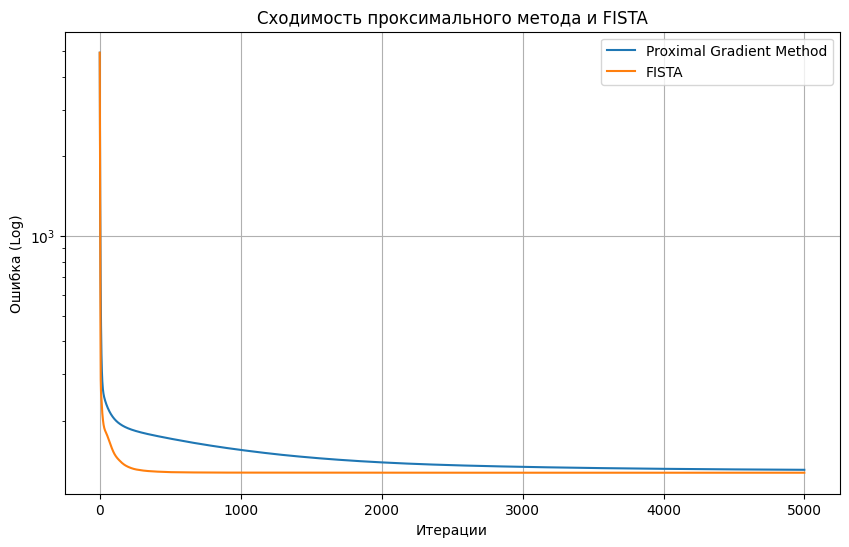

In [150]:
import numpy as np
import matplotlib.pyplot as plt

# Проксимальный оператор для неотрицательных матриц
def prox_nonnegative(matrix):
    return np.maximum(matrix, 0)

# Проксимальный оператор для L1-регуляризации
def prox_l1(matrix, gamma, lambd):
    """Проксимальный оператор для L1-регуляризации."""
    return np.sign(matrix) * np.maximum(np.abs(matrix) - gamma * lambd, 0)

# Функция ошибки
def loss(X, W, H):
    return 0.5 * np.linalg.norm(X - W @ H, "fro")**2

# Градиенты по W и H
def grad_W(X, W, H):
    return -(X - W @ H) @ H.T

def grad_H(X, W, H):
    return -W.T @ (X - W @ H)

# Проксимальный градиентный метод
def prox_grad_with_regularization(X, W, H, gamma, lambd, num_iter):
    conv = []
    for i in range(num_iter):
        # Вычисление градиентов
        grad_W_current = grad_W(X, W, H)
        grad_H_current = grad_H(X, W, H)

        # Градиентный шаг
        W -= gamma * grad_W_current
        H -= gamma * grad_H_current

        # Применение проксимальных операторов
        W = prox_l1(W, gamma, lambd)
        H = prox_l1(H, gamma, lambd)

        # Учет неотрицательности
        W = prox_nonnegative(W)
        H = prox_nonnegative(H)

        # Логирование ошибки
        current_loss = loss(X, W, H)
        conv.append(current_loss)
        if i % 1000 == 0:
            print(f"Итерация {i}: ошибка = {current_loss}")
    return W, H, conv

# FISTA (ускоренный проксимальный градиентный метод)
def fista(X, W, H, gamma, lambd, num_iter):
    t_W, t_H = 1, 1
    Z_W, Z_H = W.copy(), H.copy()
    conv = []
    for i in range(num_iter):
        # Градиентный шаг
        grad_W_current = grad_W(X, Z_W, Z_H)
        grad_H_current = grad_H(X, Z_W, Z_H)
        W_next = prox_l1(Z_W - gamma * grad_W_current, gamma, lambd)
        H_next = prox_l1(Z_H - gamma * grad_H_current, gamma, lambd)

        # Учет неотрицательности
        W_next = prox_nonnegative(W_next)
        H_next = prox_nonnegative(H_next)

        # Обновление ускорения
        t_next = (1 + np.sqrt(1 + 4 * t_W**2)) / 2
        Z_W = W_next + ((t_W - 1) / t_next) * (W_next - W)
        Z_H = H_next + ((t_H - 1) / t_next) * (H_next - H)
        W, H = W_next, H_next
        t_W, t_H = t_next, t_next

        # Логирование ошибки
        current_loss = loss(X, W, H)
        conv.append(current_loss)
        if i % 1000 == 0:
            print(f"Итерация {i}: ошибка = {current_loss}")
    return W, H, conv

# Подготовка данных
# Пример: X — набор изображений в виде матрицы (здесь просто случайные данные для теста)
np.random.seed(0)
X = np.random.rand(50, 100)  # Матрица 50x100
m, n = X.shape
k = 10  # Число признаков (шаблонов)
gamma = 0.001  # Шаг метода
lambd = 0.1  # Коэффициент регуляризации
num_iter = 5000  # Число итераций

# Инициализация
W_init = np.random.rand(m, k)
H_init = np.random.rand(k, n)

# Запуск проксимального градиентного метода
print("Запуск проксимального градиентного метода...")
W_pgm, H_pgm, conv_pgm = prox_grad_with_regularization(X, W_init.copy(), H_init.copy(), gamma, lambd, num_iter)

# Запуск FISTA
print("Запуск FISTA...")
W_fista, H_fista, conv_fista = fista(X, W_init.copy(), H_init.copy(), gamma, lambd, num_iter)

# Построение графиков
plt.figure(figsize=(10, 6))
plt.plot(conv_pgm, label="Proximal Gradient Method")
plt.plot(conv_fista, label="FISTA")
plt.yscale("log")
plt.xlabel("Итерации")
plt.ylabel("Ошибка (Log)")
plt.title("Сходимость проксимального метода и FISTA")
plt.legend()
plt.grid(True)
plt.show()


Как можно заметить FISTA сходится быстрее обчного (неускоренного) проксимального градиентного метода, однако с увелечением числа итреаций ошибка выравнивается.

__4):__

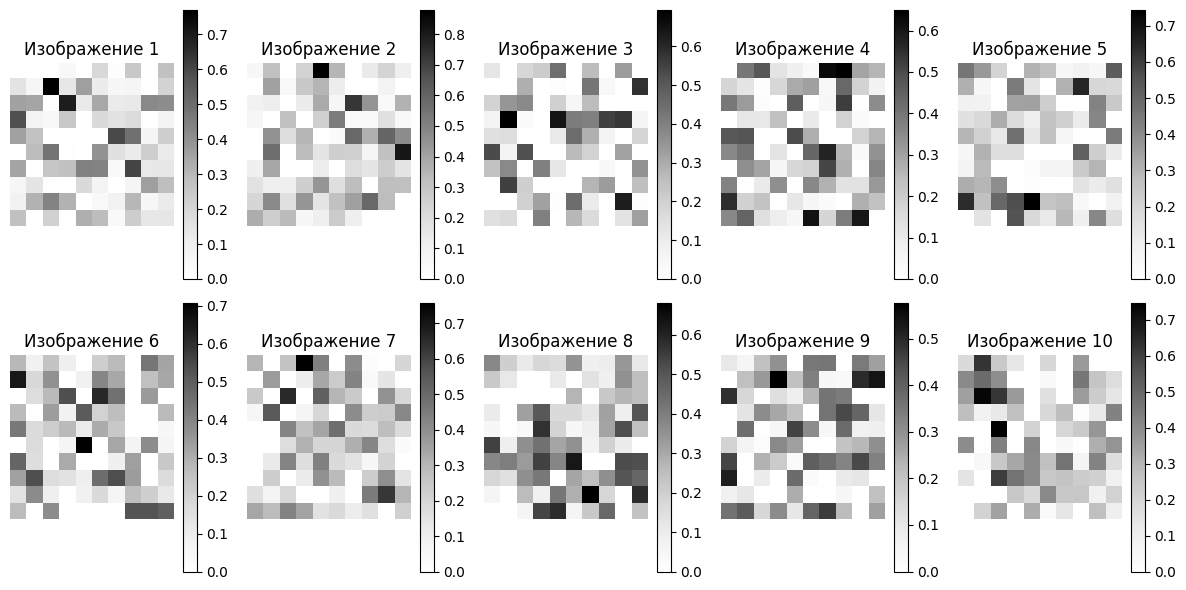

In [151]:
# Визуализация строк матрицы H как изображений
plt.figure(figsize=(12, 6))
num_images = 10  # Число изображений для отображения (можно увеличить до 50)

for i in range(num_images):
    plt.subplot(2, 5, i + 1)  # Создание сетки 2x5
    plt.imshow(H_pgm[i, :].reshape(10, -1), cmap=plt.cm.Greys)  # Преобразование строки в изображение
    plt.title(f"Изображение {i + 1}")
    plt.axis("off")
    plt.colorbar()

plt.tight_layout()
plt.show()




*   Регуляризация контролирует разреженность весов. Это означает, что каждый шаблон 𝑊 участвует только в построении некоторых объектов 𝑋.
*   Визуализация строк 𝐻 позволяет увидеть, какие шаблоны извлекаются, и убедиться, что они имеют физический смысл (проще говоря, мы видим вклад каждого шаблона через 𝐻).
*   Это потдтверждает сказанное в пункте __2)__




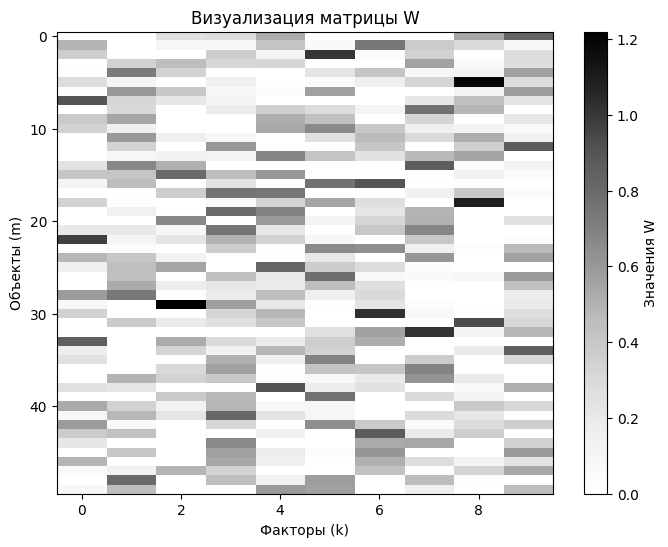

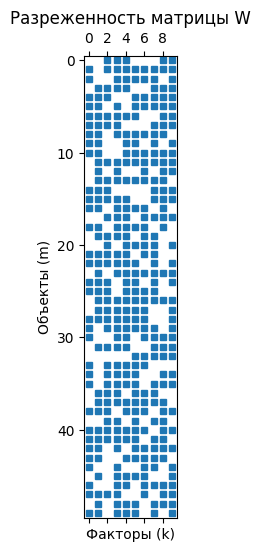

In [152]:
# Визуализация матрицы W
plt.figure(figsize=(8, 6))
plt.imshow(W_pgm, aspect='auto', cmap=plt.cm.Greys)
plt.colorbar(label="Значения W")
plt.title("Визуализация матрицы W")
plt.xlabel("Факторы (k)")
plt.ylabel("Объекты (m)")
plt.show()

# Альтернативная визуализация с помощью plt.spy (разреженность)
plt.figure(figsize=(8, 6))
plt.spy(W_pgm, markersize=5)
plt.title("Разреженность матрицы W")
plt.xlabel("Факторы (k)")
plt.ylabel("Объекты (m)")
plt.show()




*   Регуляризация делает её разреженной. Это значит, что каждый объект 𝑋 объясняется небольшим числом базисов 𝑊.
*   Сильная регуляризация приводит к тому, что лишь некоторые шаблоны активно используются, что делает результат более интерпретируемым.
*   В данном случае, т.к. матрица получилась достаточно плотная это указывает на то, что
𝐿1-регуляризация была недостаточной, и большинство объектов
𝑋 использует все шаблоны
𝐻 для восстановления.





## **Задача 4 (10 pts)**

- (3 pts) Градостроитель хотел бы выбрать местоположение $x \in \mathbb{R}^2$ для нового склада.
Оно должно быть близко к $n$ распределительным центрам, расположенным в $y_1, \ldots, y_n \in \mathbb{R}^2$.
Целевая функция для определения местоположения нового склада — это самое большое расстояние до распределительного центра.
Сформулируйте задачу выпуклой оптимизации, которая помогает определить правильное местоположение и докажите, что она является таковой.

- (3 pts) Используйте CVXPy для решения поставленной задачи. Данные для $y_i$ представлены ниже и взяты из набора данных с открытым исходным кодом о местоположении точек спроса в Сан-Франциско. Подробнее см. [здесь](https://github.com/huanfachen/Open_source_location_cover_models/tree/master).
Используйте координаты $y_i$ из переменной ```target_demand_points``` для определения координат $y_i$. Нанесите полученное оптимальное положение для склада на тот же график, что и точки спроса.

In [ ]:
# !pip install geopandas

In [1]:
import geopandas

process = lambda df: as_gdf(df).sort_values(by=["NAME"]).reset_index(drop=True)
as_gdf = lambda df: geopandas.GeoDataFrame(df, geometry=pnts(df))
pnts = lambda df: geopandas.points_from_xy(df.long, df.lat)

def plot_results_on_map(study_area, clis):
    clis = process(clis.copy())
    fig, ax = plt.subplots(figsize=(6, 9))
    markersize = 40
    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)
    gdf = geopandas.GeoDataFrame(clis["geometry"])
    zorder = 4
    gdf.plot(ax=ax, zorder=zorder, ec="k", markersize=markersize)

In [3]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

map_area = gpd.read_file('ServiceAreas_4.shp').dissolve()

demand_points = pd.read_csv('SF_demand_205_centroid_uniform_weight.csv')
n_dem_pnts = demand_points.shape[0]
demand_points.head()
# Your solution is here

,Unnamed: 0,OBJECTID,ID,NAME,STATE_NAME,AREA,POP2000,HOUSEHOLDS,HSE_UNITS,BUS_COUNT,long,lat
0,1,1,6081602900,60816029.0,California,0.48627,4135,1679,1715,112,-122.488653,37.650807
1,2,2,6081602800,60816028.0,California,0.47478,4831,1484,1506,59,-122.483550,37.659998
2,3,3,6081601700,60816017.0,California,0.46393,4155,1294,1313,55,-122.456484,37.663272
3,4,4,6081601900,60816019.0,California,0.81907,9041,3273,3330,118,-122.434247,37.662385
4,5,5,6081602500,60816025.0,California,0.46603,5146,1459,1467,44,-122.451187,37.640219


In [4]:
# Extract some part of demand points
target_demand_points = demand_points[:30]

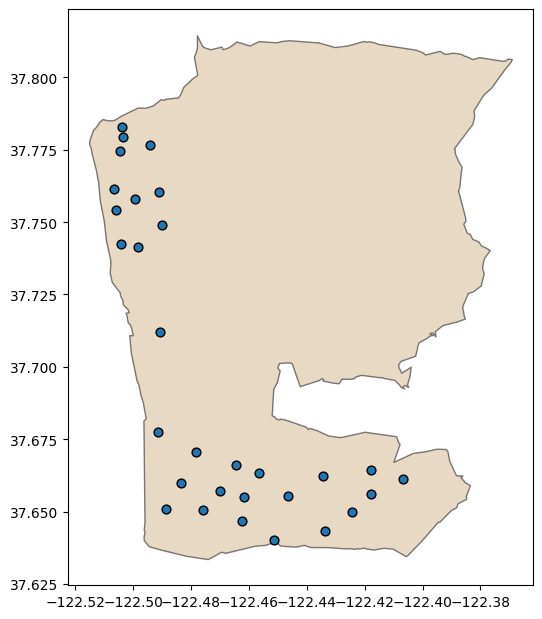

In [5]:
plot_results_on_map(map_area, clis=target_demand_points)

##**Решение:**

##__1)__ Постановка задачи через $\ell_1 $-норму

Мы хотим минимизировать максимальное расстояние по $ \ell_1 $-норме от нового склада $ x \in \mathbb{R}^2 $ до $ n $ распределительных центров $ y_1, \ldots, y_n \in \mathbb{R}^2 $. Задача формулируется как:

$$
\min_{x \in \mathbb{R}^2} \, \max_{i = 1, \ldots, n} \|x - y_i\|_1,
$$

где $ \|x - y_i\|_1 = |x_1 - y_{i,1}| + |x_2 - y_{i,2}| $.

---

## Преобразование задачи в выпуклую задачу

1. Вводим вспомогательную переменную $ t $, представляющую максимальное расстояние:
$$
\min_{x \in \mathbb{R}^2, t \in \mathbb{R}} \, t,
$$
при ограничениях:
$$
\|x - y_i\|_1 \leq t, \quad \forall i = 1, \ldots, n.
$$

2. Разворачиваем $ \ell_1 $-норму:
$$
|x_1 - y_{i,1}| + |x_2 - y_{i,2}| \leq t, \quad \forall i = 1, \ldots, n.
$$

3. Каждое выражение $ |x_1 - y_{i,1}| $ и $ |x_2 - y_{i,2}| $ заменяем двумя линейными неравенствами:
$$
-x_1 + y_{i,1} \leq t, \quad x_1 - y_{i,1} \leq t,
$$
$$
-x_2 + y_{i,2} \leq t, \quad x_2 - y_{i,2} \leq t.
$$

Итак, каждая $ \ell_1 $-норма заменяется на 4 линейных ограничения.

---

## Итоговая задача

Задача через $ \ell_1 $-норму формулируется как:
$$
\min_{x \in \mathbb{R}^2, t \in \mathbb{R}} \, t,
$$
при ограничениях:
$$
-x_1 + y_{i,1} \leq t, \quad x_1 - y_{i,1} \leq t, \quad -x_2 + y_{i,2} \leq t, \quad x_2 - y_{i,2} \leq t, \quad \forall i = 1, \ldots, n.
$$

---

## Доказательство выпуклости

1. **Целевая функция $ t $:**

Целевая функция $ t $ является линейной, а линейные функции всегда выпуклы.

2. **Ограничения:**

Каждое ограничение, например $ -x_1 + y_{i,1} \leq t $ или $ x_2 - y_{i,2} \leq t $, является линейным. Линейные ограничения задают выпуклые области.

3. **Совокупная задача:**

Задача минимизации линейной функции $ t $ на выпуклом множестве (заданном линейными ограничениями) является выпуклой.

---

## Вывод

Через $ \ell_1 $-норму задача минимизации формулируется как задача линейного программирования, которая является выпуклой:
$$
\min_{x \in \mathbb{R}^2, t \in \mathbb{R}} \, t,
$$
при линейных ограничениях:
$$
-x_1 + y_{i,1} \leq t, \quad x_1 - y_{i,1} \leq t, \quad -x_2 + y_{i,2} \leq t, \quad x_2 - y_{i,2} \leq t, \quad \forall i = 1, \ldots, n.
$$


##__2):__

In [24]:
import cvxpy as cp

# Используем первые 30 точек спроса
target_demand_points = demand_points[:30]
y_coords = target_demand_points[["long", "lat"]].values

# Переменные оптимизации
x = cp.Variable(2)  # Координаты склада: [x1, x2]
t = cp.Variable()   # Максимальное расстояние (скаляр)

# Ограничения для каждой точки спроса
constraints = []
for y in y_coords:
    constraints.append(cp.abs(x[0] - y[0]) + cp.abs(x[1] - y[1]) <= t)

# Целевая функция
objective = cp.Minimize(t)

# Постановка задачи
problem = cp.Problem(objective, constraints)

# Решение
problem.solve()

0.10920602246785205

Оптимальное местоположение склада: [-122.4795755    37.69770548]
Максимальное расстояние до точки спроса: 0.10920602246785205


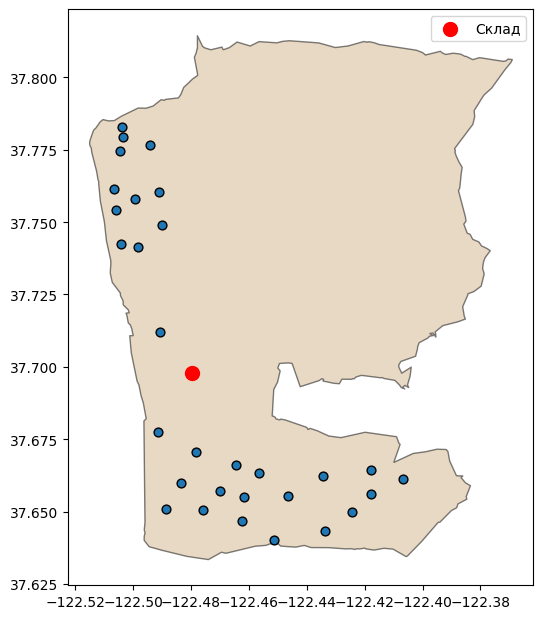

In [25]:
# Результаты
optimal_location = x.value
print(f"Оптимальное местоположение склада: {optimal_location}")
print(f"Максимальное расстояние до точки спроса: {t.value}")

# Визуализация результатов
def plot_results_on_map(study_area, clis, warehouse_location):
    clis = process(clis.copy())
    fig, ax = plt.subplots(figsize=(6, 9))
    markersize = 40
    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)
    gdf = geopandas.GeoDataFrame(clis["geometry"])
    zorder = 4
    gdf.plot(ax=ax, zorder=zorder, ec="k", markersize=markersize)
    ax.scatter(*warehouse_location, color='red', label='Склад', s=100, zorder=5)
    ax.legend()
    plt.show()

# Отображение на карте
plot_results_on_map(map_area, clis=target_demand_points, warehouse_location=optimal_location)

- (4 pts) Визуализация координат распределительных центров показывает, что на самом деле у нас есть две группы центров, которые должны обслуживаться двумя разными складами.
Переформулируйте исходную задачу таким образом, чтобы её решение определяло позиции двух складов и автоматически назначала каждуый центр целевому складу. Введите новые переменные, если необходимо, и попробуйте решить её с помощью CVXPy. Чтобы сделать задачу подходящей для CVXPy, вы можете выбрать способ измерения расстояний такой, что итоговая задача станет задачей из класса смешанного целочисленного линейного программирования.

##__3):__

## Постановка задачи с двумя складами

Задачу сводим к определению местоположений двух складов $ x_1 \in \mathbb{R}^2 $ и $ x_2 \in \mathbb{R}^2 $, а также назначению каждого распределительного центра $ y_i $ одному из складов так, чтобы минимизировать максимальное расстояние $( \ell_1 $-норма) между складом и распределительными центрами.

---

## Новая постановка задачи

### Переменные:
- $ x_1 $ и $ x_2 $: координаты двух складов $( \mathbb{R}^2 )$.
- $ t $: максимальное расстояние между складом и ближайшим распределительным центром.
- $ z_{i1}, z_{i2} $: бинарные переменные $( z_{ij} \in \{0, 1\} )$ для указания, обслуживается ли точка $ y_i $ складом $ x_1 $ или $ x_2 $.

### Целевая функция:
$$
\min_{x_1, x_2, t, z_{ij}} \, t
$$

### Ограничения:
1. Каждая точка $ y_i $ должна быть обслужена только одним складом:
   $$
   z_{i1} + z_{i2} = 1, \quad \forall i.
   $$
2. Если $ y_i $ обслуживается складом $ x_j $, то расстояние от $ y_i $ до $ x_j $ по $ \ell_1 $-норме должно быть не больше $ t $:
   $$
   |x_{j,1} - y_{i,1}| + |x_{j,2} - y_{i,2}| \leq t + M \cdot (1 - z_{ij}), \quad \forall i, j,
   $$
   где $ M $ — большое число, чтобы убрать ограничение, если $ z_{ij} = 0 $.

---

## Примечания
- $ t $: минимизируемое значение, представляющее максимальное расстояние до складов.
- $ z_{ij} $: бинарная переменная, которая принимает значение 1, если $ y_i $ обслуживается складом $ x_j $, и 0 — в противном случае.
- $ M $: большое положительное число, позволяющее "выключать" ограничение для несоответствующих складов.

Эта задача сводится к задаче смешанного целочисленного программирования (Mixed-Integer Linear Programming, MILP), подходящей для решения с помощью специальных солверов, таких как GUROBI (нужна лицензия) или другой (выбрал GLPK_MI).


In [30]:
%pip install ecos


In [31]:
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'GUROBI', 'OSQP', 'SCIP', 'SCIPY', 'SCS']


In [36]:
# Число точек спроса и большое число для M
n_points = len(y_coords)
M = 1e4

# Переменные
x1 = cp.Variable(2)  # Координаты склада 1
x2 = cp.Variable(2)  # Координаты склада 2
t = cp.Variable()    # Максимальное расстояние
z = cp.Variable((n_points, 2), boolean=True)  # Бинарные переменные

# Ограничения
constraints = []

# Каждая точка обслуживается одним складом
for i in range(n_points):
    constraints.append(z[i, 0] + z[i, 1] == 1)

# Ограничения на расстояния
for i in range(n_points):
    for j, x in enumerate([x1, x2]):
        constraints.append(cp.abs(x[0] - y_coords[i, 0]) + cp.abs(x[1] - y_coords[i, 1]) <= t + M * (1 - z[i, j]))

# Целевая функция
objective = cp.Minimize(t)

# Постановка задачи
problem = cp.Problem(objective, constraints)

# Решение задачи с указанием солвера
problem.solve(solver=cp.GLPK_MI)  # Можно заменить на cp.CBC, cp.SCIP и др.

# Результаты
print(f"Оптимальное местоположение склада 1: {x1.value}")
print(f"Оптимальное местоположение склада 2: {x2.value}")
print(f"Максимальное расстояние до точек спроса: {t.value}")

Оптимальное местоположение склада 1: [-122.50641005   37.77512215]
Оптимальное местоположение склада 2: [-122.4782804    37.67061016]
Максимальное расстояние до точек спроса: 0.013688236999659154


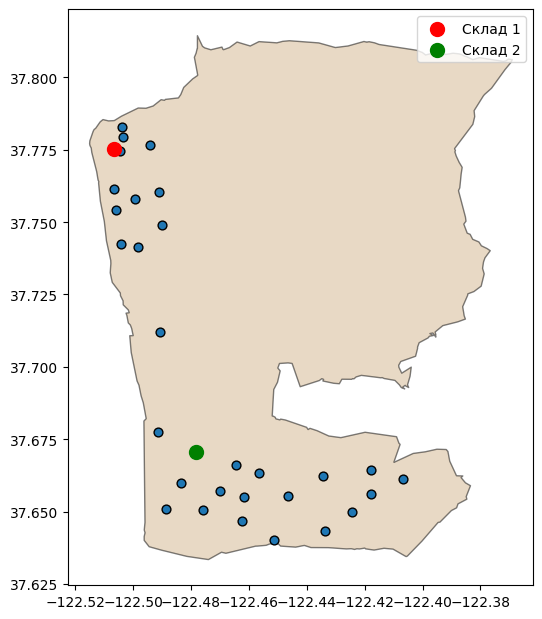

In [37]:
import geopandas as gpd
import matplotlib.pyplot as plt

# Функция для визуализации результатов
def plot_results_on_map(study_area, clis, warehouse_locations):
    clis = process(clis.copy())  # Предполагается, что process – это функция для предобработки clis
    fig, ax = plt.subplots(figsize=(6, 9))
    markersize = 40
    # Отображаем область исследования (например, карту города)
    study_area.plot(ax=ax, alpha=0.5, fc="tan", ec="k", zorder=1)

    # Отображаем точки спроса
    gdf = gpd.GeoDataFrame(clis["geometry"])
    zorder = 4
    gdf.plot(ax=ax, zorder=zorder, ec="k", markersize=markersize)

    # Отображаем местоположение двух складов
    ax.scatter(*warehouse_locations[0], color='red', label='Склад 1', s=100, zorder=5)
    ax.scatter(*warehouse_locations[1], color='green', label='Склад 2', s=100, zorder=5)

    # Настройки графика
    ax.legend()
    plt.show()

# Пример использования функции
optimal_locations = [x1.value, x2.value]
plot_results_on_map(map_area, clis=target_demand_points, warehouse_locations=optimal_locations)
